# 1)      Валідація двох альтернатив: additive VS multiplicative;

2)      Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

3)      Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;

4)      Тренування та валідація MA, AR, ARMA, ARIMA моделей;

5)      Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

6)      Висновки щодо того, яку модель краще використовувати;

7)      Прогноз на наступний рік

8)      На основі одержаного прогнозу планування ресурсів на наступний рік, використовуючи додаткову інформацію:

# Initialise environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import datetime 
import time
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [2]:
import warnings
warnings.simplefilter(action='ignore')
#getting rid of anoing "Warnings"

# reading data from files 

In [3]:
REGION =   ['PRK', 'Perak', 'PRK'] # <==== variant = ...30 % 7 = 2, selecting third region 

In [4]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [5]:
production.head()

index Region  Year  Month  Production  Diff_production
0      0     JH  1998      1     118.359            0.000
1      1     JH  1998      2     147.988            0.000
2      2     JH  1998      3     145.514           29.629
3      3     JH  1998      4     154.638           -2.474
4      4     JH  1998      5     155.827            9.124

In [6]:
rainfall.head()

Region  Year  Month    Rainfall
0  Johor  1980      1  254.566667
1  Johor  1981      1   67.500000
2  Johor  1982      1  124.833333
3  Johor  1983      1  149.866667
4  Johor  1984      1  446.900000

In [7]:
area.head()

Area_New  Area_ma  Area_ma_new  Area_npa  Area_rpa Region  Year
0       0.0      0.0     0.000000       0.0       0.0     JH  1974
1      59.0    128.0   128.000000     187.0       0.0     JH  1975
2      59.0    147.0   147.000000     206.0       0.0     JH  1976
3      56.0    171.0   116.538462     227.0       0.0     JH  1977
4      59.0    191.0    93.423077     250.0       0.0     JH  1978

In [8]:
RAINFALL_LAGS = [ 9, 10, 11, 12, 18, 24, 36] 
# < ===== add more lags for further exploration of severale eyars cycles and differencing of those data 
# (a.e. wether shorter period shows differs from general trend)
PRODUCTION_LAGS = [ 9, 10, 11, 12, 18, 24, 36]

In [9]:
def process_data(production, rainfall, area, region, PRODUCTION_LAGS, RAINFALL_LAGS):
    data = production[production.Region == region[0]]
    data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                    rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == region[2]][
        ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                   inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))

#     for lag in RAINFALL_LAGS:
#         temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
#         data['Rainfall_{0}'.format(lag)] = temp

#     for lag in PRODUCTION_LAGS:
#         temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
#         data['Production_{0}'.format(lag)] = temp

    PRODUCTION = data.Production
#     data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)



    # I prefere to do it closer to place of model tuning =0)

    #  And clip first year
    for col in data.columns:
        data['_'.join([region[1], str(col)])] = data[col]
        data.drop([col], axis=1, inplace=True)
        
    return (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])


In [10]:
#Read down variant
DATA = process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS)

In [11]:
DATA[0].tail()

Perak_Month  Perak_Production  Perak_Rainfall  Perak_Area_ma  \
2017-05-01            5           186.958          129.33     312.421053   
2017-06-01            6           165.175          105.82     312.421053   
2017-07-01            7           202.661           85.98     312.421053   
2017-08-01            8           188.525          122.78     312.421053   
2017-09-01            9           171.271          104.88     312.421053   

            Perak_Area_npa  Perak_Area_rpa  Perak_Area_ma_new  Perak_Time  
2017-05-01      349.157895        8.263158         153.390283         232  
2017-06-01      349.157895        8.263158         153.390283         233  
2017-07-01      349.157895        8.263158         153.390283         234  
2017-08-01      349.157895        8.263158         153.390283         235  
2017-09-01      349.157895        8.263158         153.390283         236

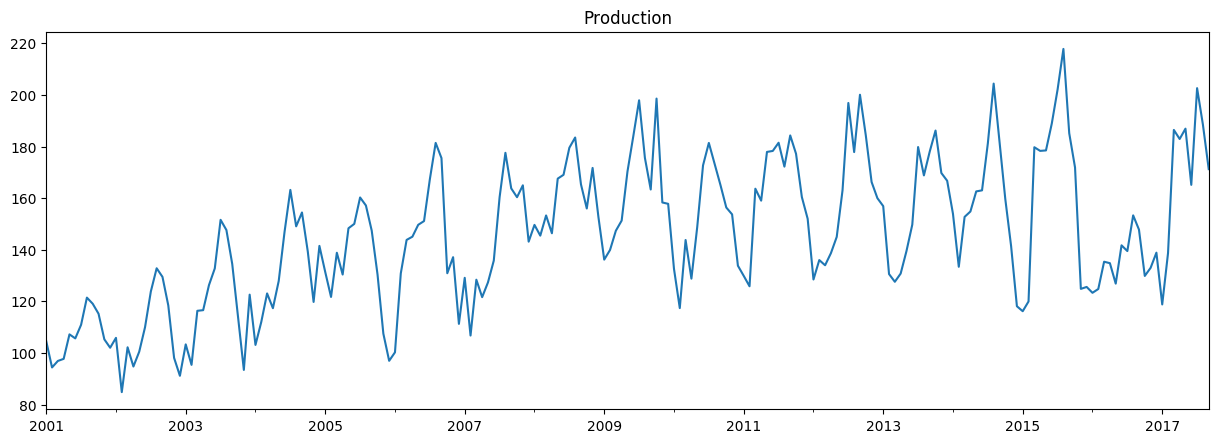

In [12]:
raw_ts = DATA[1]
raw_ts.plot(title = 'Production')

# 1)      Валідація двох альтернатив: additive VS multiplicative;
### If the TS has multiplicative nature we can explect the growth in amplitude of values during period (it is explained with propperty that change of magnitude in one variable of product (Seson*Trend*Residuals) will affect resulting data. We can observe it like increase or decrease of seasonal oscilations. 
## Therefore check those properties along our timeseries:

## presume that whe know appropriate seasonality (we know that crop cycle is 1 year)

In [13]:
SEASON_Hypothesis = 12 # <==== our initial hypothesis about seasonality in data 
# (as we deal with argiculture, natural cycles should be appropriate)

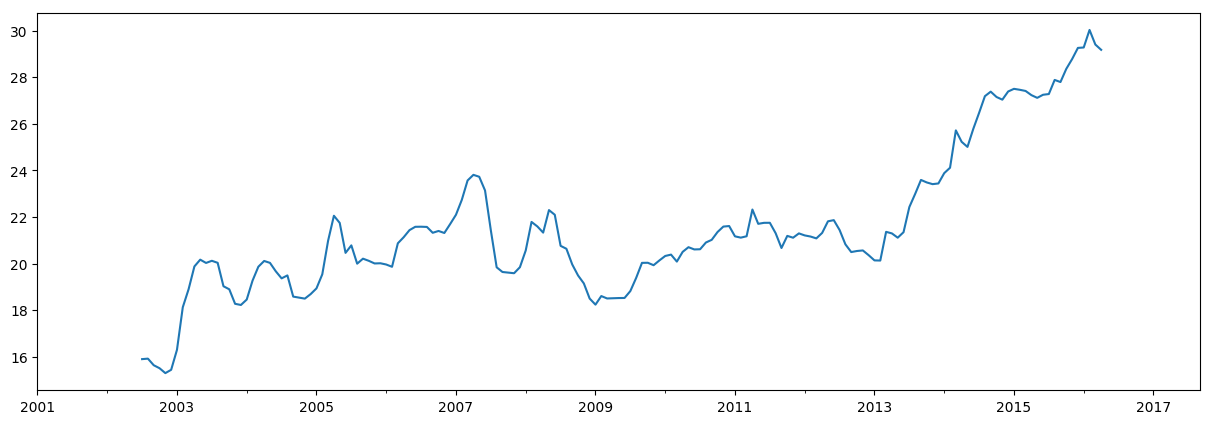

In [14]:
raw_ts.rolling(3*SEASON_Hypothesis, center=True).std().plot()

In [15]:
#can't use pdp on default 
def my_centered_roll (window_size, data, np_function,step):
    spans = []
    side_offset = window_size // 2
    
    start = 0
    end = start + window_size
    while end < len(data):
        piece = data[start:end]
        spans.append(np_function(piece))
        end+=step
        start+=step
    return spans

In [16]:
def ts_from_data(data, index):
    return pd.Series(data = data, index = index[-len(data):])

In [17]:
pdps = my_centered_roll(3*SEASON_Hypothesis, raw_ts, np.ptp, SEASON_Hypothesis)
print(np.mean(pdps))

83.4362142857


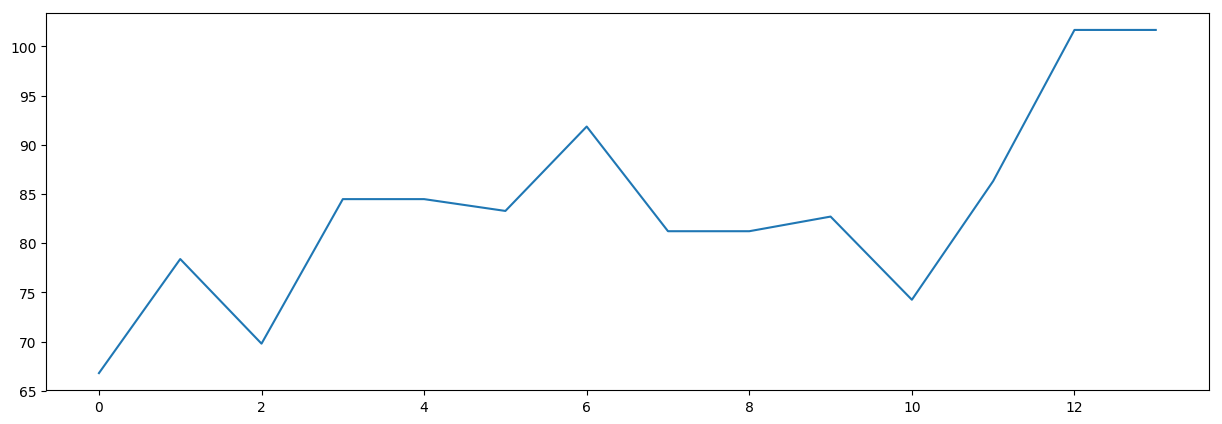

In [18]:
plt.plot(pdps)

## As we observe, there is increase in magnitude of data, therefore process migh be multiplicative.  Allso it's center is far from zero.

## To avoid possible problems with valdation of aditional hypothesis, LOG series values.

In [19]:
ts_log = np.log (raw_ts)

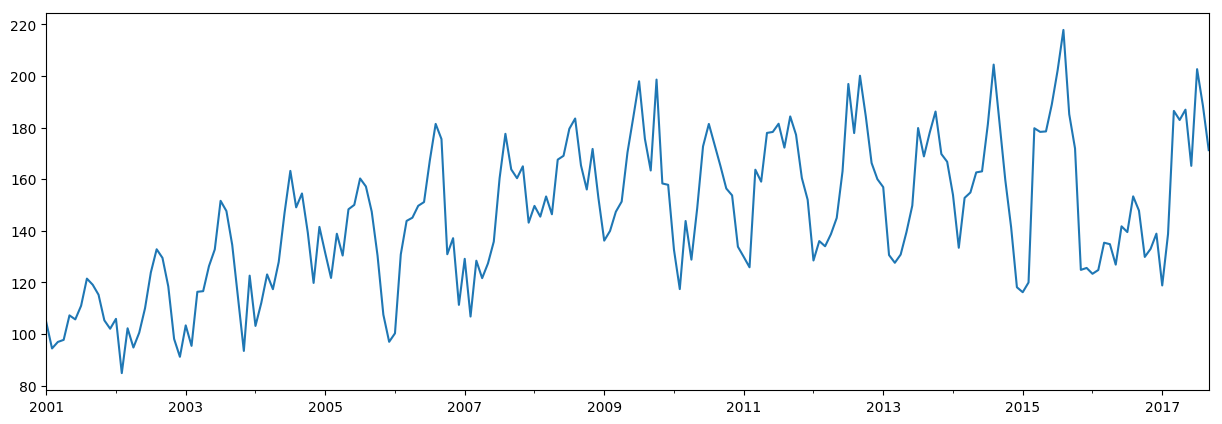

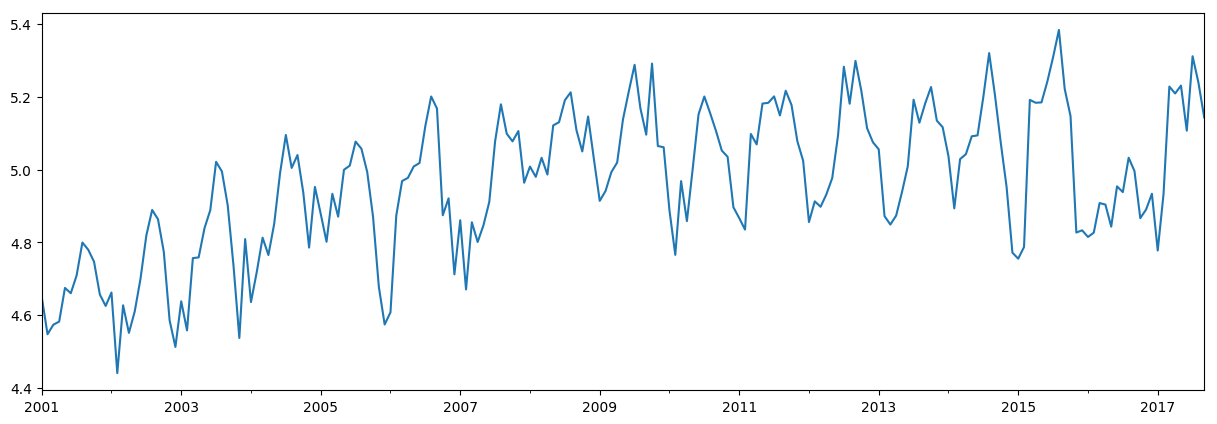

In [20]:
raw_ts.plot()
plt.show()
ts_log.plot()

0.580444662066


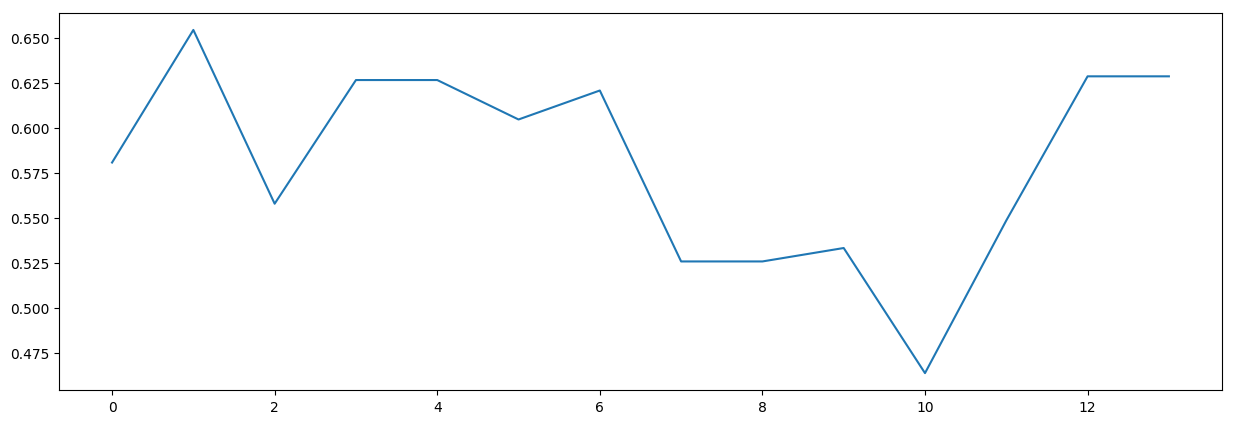

In [21]:
log_pdps = my_centered_roll(3*SEASON_Hypothesis, ts_log, np.ptp, SEASON_Hypothesis)
print(np.mean(log_pdps))
plt.plot(log_pdps)

 ## As we see oscilations amplitude decreased dramatically and become zero-centered, assume hypothesis of multiplicative nature of data confirmed.

# 2) Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

# Stationarity 
## we will use Dickey-Fuller test to determine is there left significant time-dependand part in our data

In [22]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    
    
def small_stat_test(ts):
    result = adfuller(ts)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### As expected we obtain large p-value () , and statistics value significantly larger then critical values for 10%, 5%, 1% probability to reject hypothesis of non-stationarity.

Results of Dickey-Fuller Test:
(-2.1279222481093365, 0.23343613510434752, 12, 188, {'5%': -2.8770397560752436, '1%': -3.4656203971241921, '10%': -2.5750324547306476}, -334.55698408724413)
Test Statistic                  -2.127922
p-value                          0.233436
#Lags Used                      12.000000
Number of Observations Used    188.000000
Critical Value (5%)             -2.877040
Critical Value (1%)             -3.465620
Critical Value (10%)            -2.575032
dtype: float64


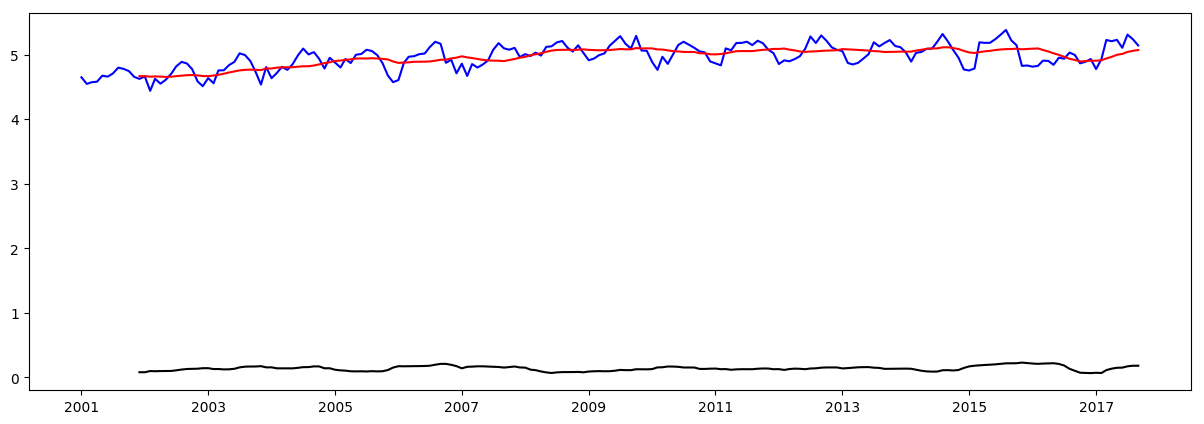

In [23]:
stationarity_test(ts_log)

# Moving avarage analysys
This kind of analysys gives us estimation of general trend over our dataset, as we see, 3 cycles are generally enought for avoding seasonal oscilations

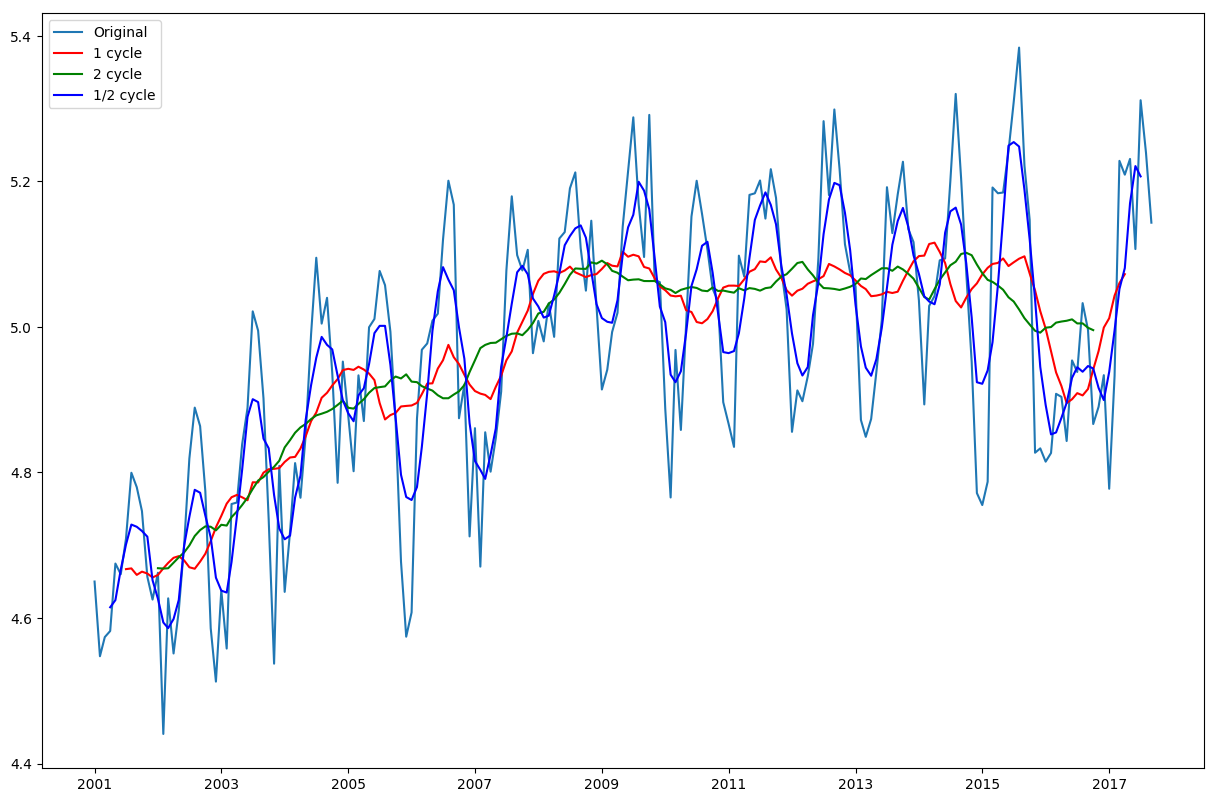

In [24]:
ts_moving_avg_center1 = ts_log.rolling(SEASON_Hypothesis, center=True).mean()
ts_moving_avg_center1.dropna(inplace=True)

ts_moving_avg_center2 = ts_log.rolling(2*SEASON_Hypothesis, center=True).mean()
ts_moving_avg_center2.dropna(inplace=True)

ts_moving_avg_center05 = ts_log.rolling(SEASON_Hypothesis//2, center=True).mean()
ts_moving_avg_center05.dropna(inplace=True)

matplotlib.rcParams['figure.figsize'] = 15, 10
plt_original, = plt.plot(ts_log, )
plt_1cycle, =plt.plot(ts_moving_avg_center1, color='red')
plt_2cycle, =plt.plot(ts_moving_avg_center2, color='green')
plt_0_5cycle, =plt.plot(ts_moving_avg_center05, color='blue')
plt.legend(
    [plt_original, plt_1cycle, plt_2cycle,  plt_0_5cycle],
           ['Original', '1 cycle', '2 cycle', '1/2 cycle']
)

#restore previous
matplotlib.rcParams['figure.figsize'] = 15, 5

## Detrended data (shocks)

In [25]:
print(ts_log.mean())
print (" Mean=[{}]   STD= [{}]  PTP = [{}] Original".format(
    (ts_log  ).mean(),
    (ts_log  ).std(),
    (ts_log  ).ptp()
)) 
log_dif_cycle1 = ts_log - ts_moving_avg_center1
log_dif_cycle1.dropna(inplace= True)
print (" Mean=[{}]   STD= [{}]   PTP = [{}] 1 cycle".format(  
    log_dif_cycle1.mean(),
    log_dif_cycle1.std(),
    log_dif_cycle1.ptp())
)
log_dif_cycle2 = ts_log - ts_moving_avg_center2
log_dif_cycle2.dropna(inplace= True)
print (" Mean=[{}]   STD= [{}]   PTP = [{}]  2 cycle".format( 
    log_dif_cycle2.mean(),
    log_dif_cycle2.std(),
    log_dif_cycle2.ptp())
)

log_dif_cycle05 = ts_log - ts_moving_avg_center05
log_dif_cycle05.dropna(inplace= True)
print (" Mean=[{}]   STD= [{}]   PTP = [{}]  1/2 cycle".format( # < === severe lost of variance
    log_dif_cycle05.mean(),
    log_dif_cycle05.std(),
    log_dif_cycle05.ptp())
)


4.96187448935
 Mean=[4.961874489353987]   STD= [0.1974432363990559]  PTP = [0.9432643252925885] Original
 Mean=[0.0009571413290959382]   STD= [0.13484345719358384]   PTP = [0.6072318423428147] 1 cycle
 Mean=[-0.001597575524374862]   STD= [0.1441391524015128]   PTP = [0.7203854100132201]  2 cycle
 Mean=[0.00181174279909908]   STD= [0.08196014894040671]   PTP = [0.44434233684697233]  1/2 cycle


## clearify what type of used MA trend is the best with test

In [26]:
small_stat_test(log_dif_cycle1)
small_stat_test(log_dif_cycle2)
small_stat_test(log_dif_cycle05)

ADF Statistic: -6.223864
p-value: 0.000000
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576
ADF Statistic: -6.441245
p-value: 0.000000
Critical Values:
	5%: -2.879
	1%: -3.471
	10%: -2.576
ADF Statistic: -6.337301
p-value: 0.000000
Critical Values:
	5%: -2.877
	1%: -3.466
	10%: -2.575


##  As 1/2 cycle MA allso gets away part of seasonality,  we see that best detrending occures when we are taking 1-cycled intervals in consiveration

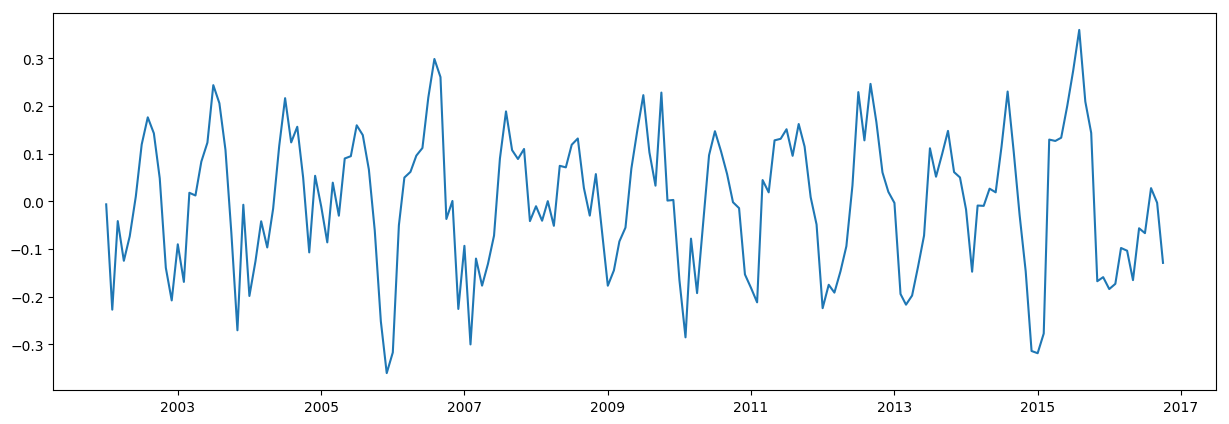

In [27]:
ts_detrended_MA = ts_log - ts_moving_avg_center2
plt.plot(ts_detrended_MA)

### As we observe that best centered result were obtained with approximation equalt to 1 Cycle, we can assume that our hypothesis about cycle length is valid.

# Exponential Smoothing
### This analysys type used for approximations of ts, reconstruction and short-term predictions of TS, main feature is that we use 'weighed' sum of a series episodes, usually giving more weight to closer episodes then to decent ones (in real TS close episodes have bigger autocorrelation). Allso it is good because we preserve all data period (tail and head of TS)

In [28]:
def exp_approximation(data, halflife = 1, plot = True):
    expwighted_avg = pd.ewma(ts_log, halflife=halflife)
    if plot:
        orig, = plt.plot (ts_log)
        exp_w, = plt.plot(expwighted_avg)
        plt.legend(
            [orig, exp_w],
            ['original', 'exp_weighted']
        )
    return expwighted_avg

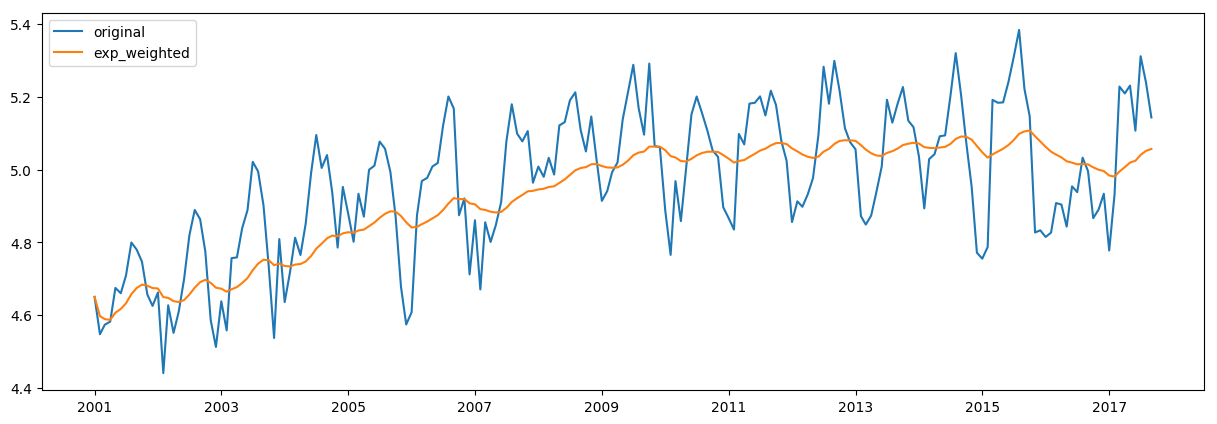

In [29]:
expwighted_avg = exp_approximation (ts_log, SEASON_Hypothesis)

ADF Statistic: -3.404854
p-value: 0.010795
Critical Values:
	5%: -2.877
	1%: -3.466
	10%: -2.575


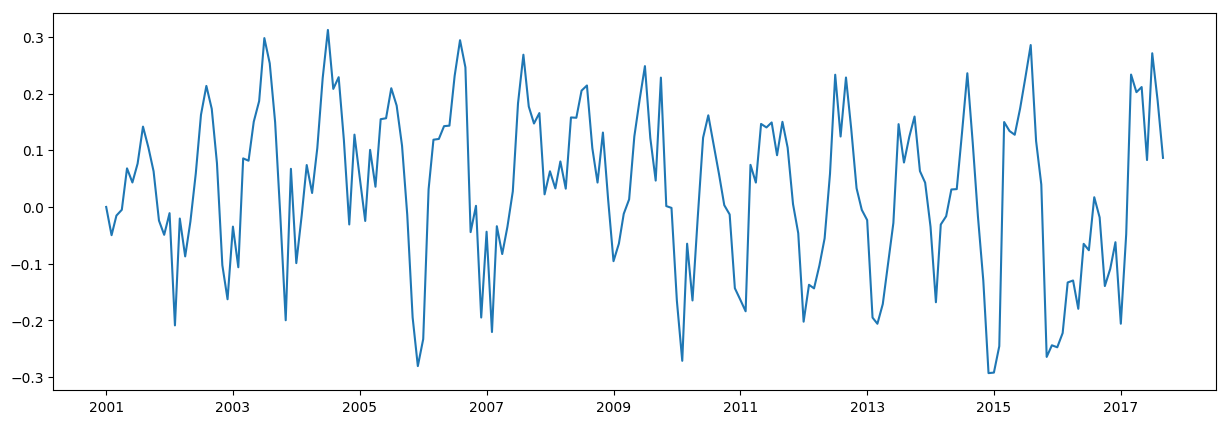

In [30]:
exp_detrended = ts_log - expwighted_avg
plt.plot(exp_detrended)

small_stat_test(exp_detrended)

## As we see here expsmoothing performes great in trend extraction from data

Results of Dickey-Fuller Test:
(-3.40485382134742, 0.01079451388820785, 12, 188, {'5%': -2.8770397560752436, '1%': -3.4656203971241921, '10%': -2.5750324547306476}, -354.80620938636605)
Test Statistic                  -3.404854
p-value                          0.010795
#Lags Used                      12.000000
Number of Observations Used    188.000000
Critical Value (5%)             -2.877040
Critical Value (1%)             -3.465620
Critical Value (10%)            -2.575032
dtype: float64


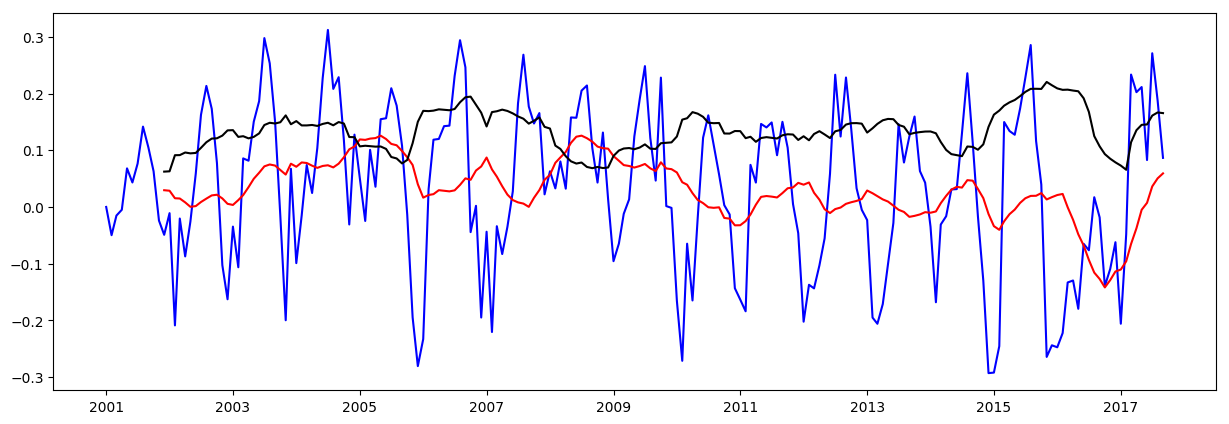

In [31]:
stationarity_test(exp_detrended)

# Differencing

## We can apply this method to state what parameter d we have to use as ARIMA parameter to obtain stationarity of a model
# First order of differentiation removes constant component of first order (linear trend). In our situations it can be sutable. But moreover, if we perform same first order of differentiating with  step corresponding to a seasonality period of our data we will get doble benefit with one operation.

# Test for exact season cycle period effects:

In [32]:
def analyse_for_best_shift(data, search_range):
    ADF_statistics =  [ adfuller( data.diff(shift)[shift:] )[0] for shift in search_range]
    shifts_effect = ts_from_data(ADF_statistics, search_range)
    shifts_effect.plot()
    plt.xticks(search_range)
    plt.grid(True)
    plt.show()
    return ADF_statistics

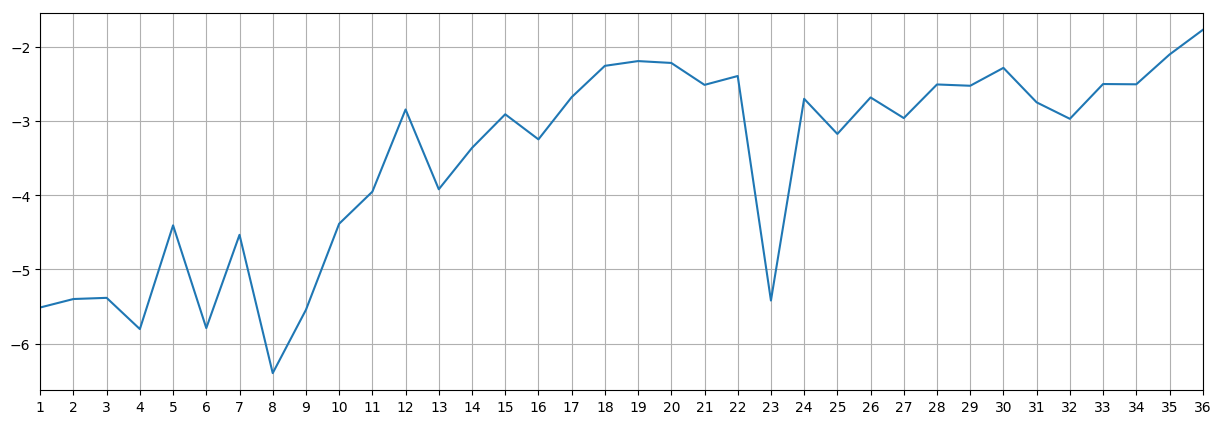

In [33]:
analyse_for_best_shift( 
    data = ts_log, 
    search_range = np.array(range(1, 3*SEASON_Hypothesis + 1)) 
);

## As we see, surprisingly data has some period distinct from expexted 12 monthes, but only 8, what we-ve missed during MA analysys.

Results of Dickey-Fuller Test:
(-6.3982217496883145, 2.0257753903440897e-08, 15, 177, {'5%': -2.8780117454974392, '1%': -3.4678453197999071, '10%': -2.575551186759871}, -257.07971315995371)
Test Statistic                -6.398222e+00
p-value                        2.025775e-08
#Lags Used                     1.500000e+01
Number of Observations Used    1.770000e+02
Critical Value (5%)           -2.878012e+00
Critical Value (1%)           -3.467845e+00
Critical Value (10%)          -2.575551e+00
dtype: float64


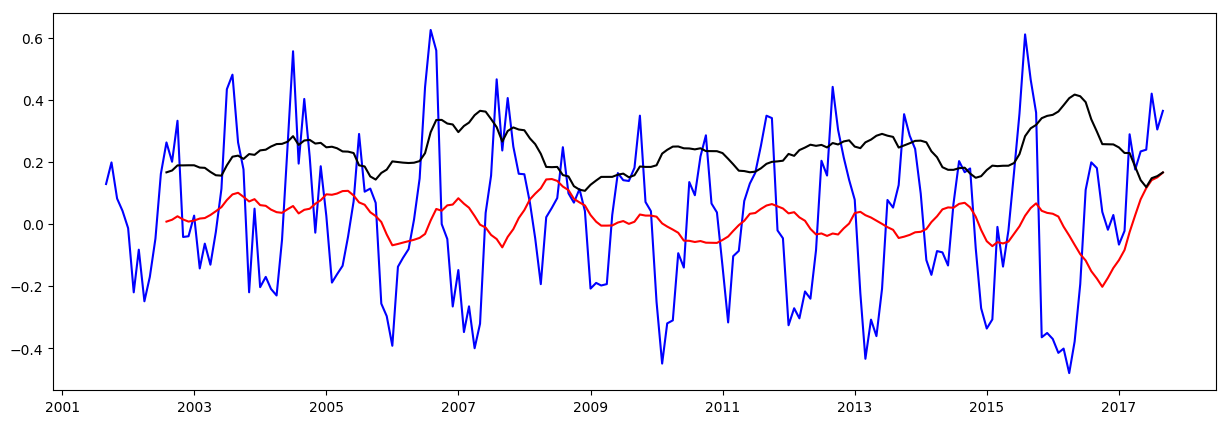

In [34]:
ts_log_dif_8 = ts_log.diff(periods=8)
ts_log_dif_8.dropna(inplace=True)
stationarity_test(ts_log_dif_8)

Results of Dickey-Fuller Test:
(-2.8422858114382925, 0.052482788179547511, 14, 174, {'5%': -2.8782983668563396, '1%': -3.4685016947910636, '10%': -2.5757041590698901}, -290.35961478642741)
Test Statistic                  -2.842286
p-value                          0.052483
#Lags Used                      14.000000
Number of Observations Used    174.000000
Critical Value (5%)             -2.878298
Critical Value (1%)             -3.468502
Critical Value (10%)            -2.575704
dtype: float64


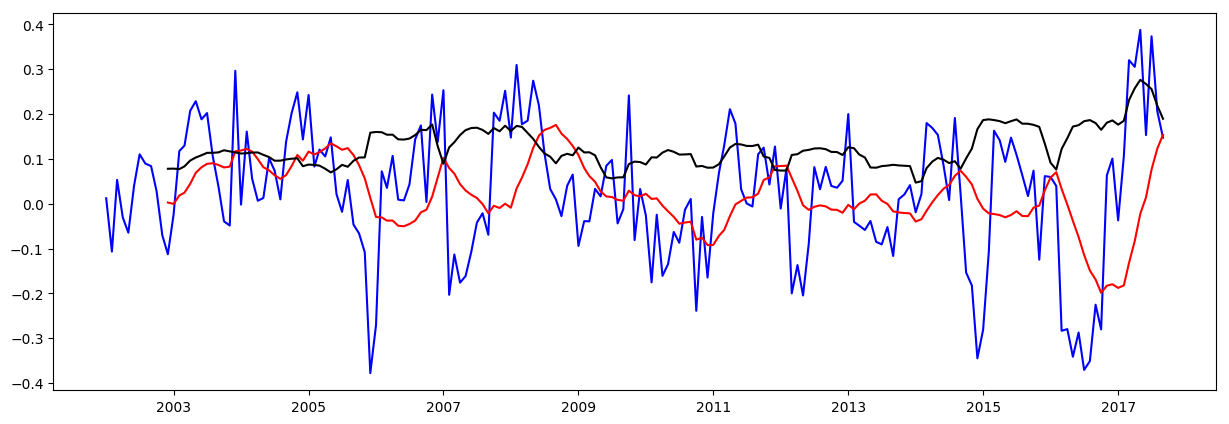

In [35]:
ts_log_dif_12 = ts_log.diff(periods=SEASON_Hypothesis)
ts_log_dif_12.dropna(inplace=True)
stationarity_test(ts_log_dif_12)

Results of Dickey-Fuller Test:
(-3.1085698457760986, 0.025925447765751928, 14, 162, {'5%': -2.8795521079291966, '1%': -3.4713743456470239, '10%': -2.5763733302850174}, -162.15545184726057)
Test Statistic                  -3.108570
p-value                          0.025925
#Lags Used                      14.000000
Number of Observations Used    162.000000
Critical Value (5%)             -2.879552
Critical Value (1%)             -3.471374
Critical Value (10%)            -2.576373
dtype: float64


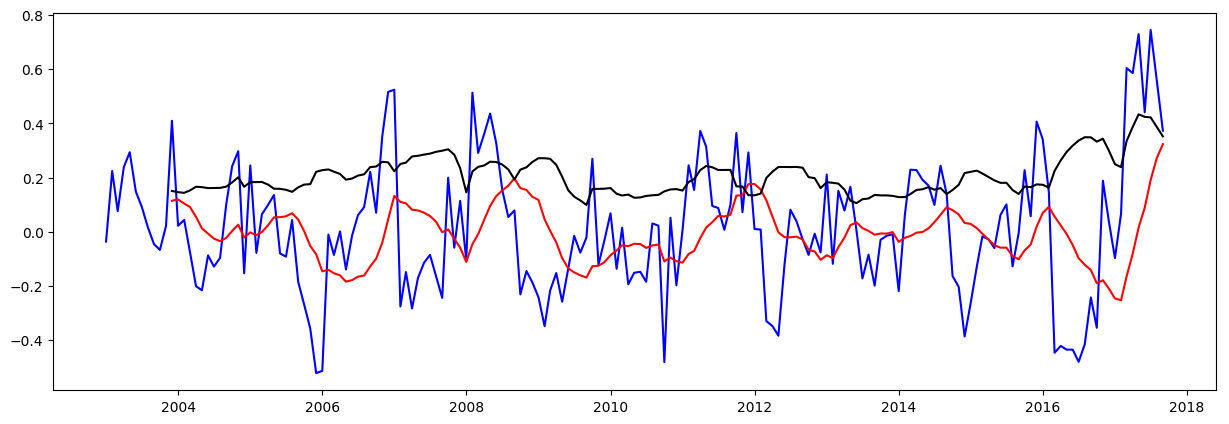

In [36]:
ts_log_dif_12_12 = ts_log_dif_12.diff(periods=SEASON_Hypothesis)
ts_log_dif_12_12.dropna(inplace=True)
stationarity_test(ts_log_dif_12_12)

## We see that stationarity with first difference of 8 is better allmost as good as the second difference with 1-year hypothesis

In [37]:
SEASON_Hypothesis = 8

# 3) Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;
### As we've allready performed differencing analysys, here just add decomposition example and check result with tests performed by library function and compare with our version.

In [38]:
# TF decompose
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq, model='additive', two_sided=False)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return residual, trend, seasonal

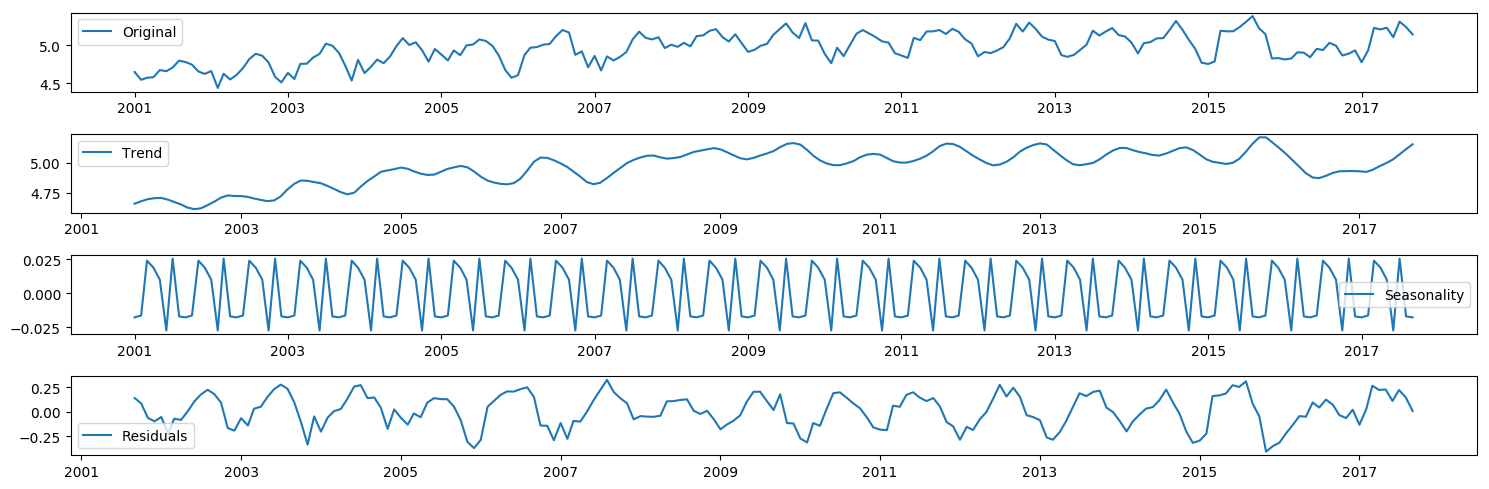

In [39]:
ts_log_decomposed_residuals, ts_log_decomposed_trend, ts_log_decomposed_seasonal =\
_decompose(ts_log, SEASON_Hypothesis)

ts_log_decomposed_residuals.dropna(inplace=True)
ts_log_decomposed_trend.dropna(inplace=True)
ts_log_decomposed_seasonal.dropna(inplace=True)

Results of Dickey-Fuller Test:
(-5.3577048374372138, 4.1535502020789146e-06, 13, 179, {'5%': -2.8778260518445382, '1%': -3.4674201432469816, '10%': -2.5754520823320122}, -352.55425389302911)
Test Statistic                  -5.357705
p-value                          0.000004
#Lags Used                      13.000000
Number of Observations Used    179.000000
Critical Value (5%)             -2.877826
Critical Value (1%)             -3.467420
Critical Value (10%)            -2.575452
dtype: float64


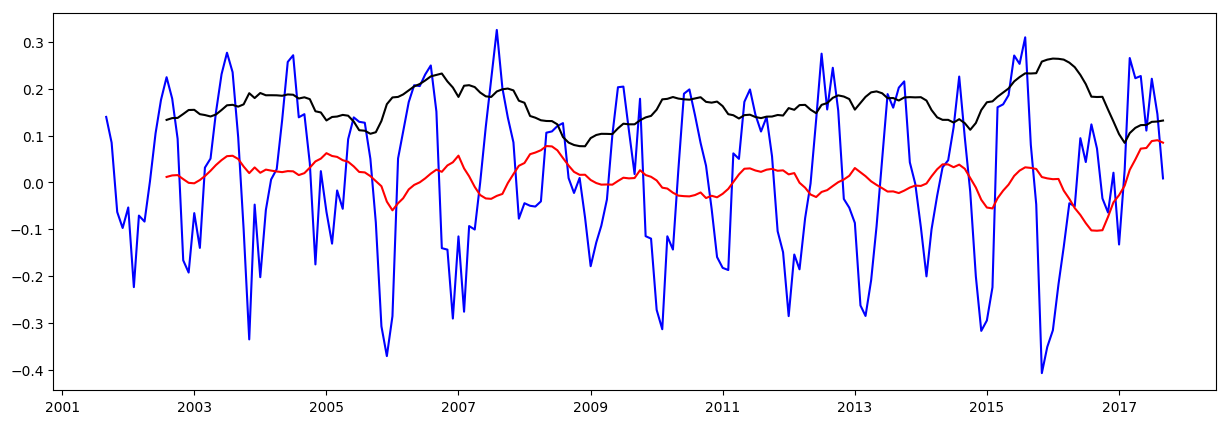

In [40]:
stationarity_test(ts_log_decomposed_residuals)

## We allso need to exemine trend component, because in case of prediction we'll need to fit allso (here our extra-data can come in hand)

In [41]:
small_stat_test(ts_log_decomposed_trend)

ADF Statistic: -3.799021
p-value: 0.002917
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576


## As we deal with decomposition on three parts, we'll allso try the same approach

In [42]:
small_stat_test(ts_log_dif_8)

ADF Statistic: -6.398222
p-value: 0.000000
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576


In [43]:
small_stat_test(exp_detrended)

ADF Statistic: -3.404854
p-value: 0.010795
Critical Values:
	5%: -2.877
	1%: -3.466
	10%: -2.575


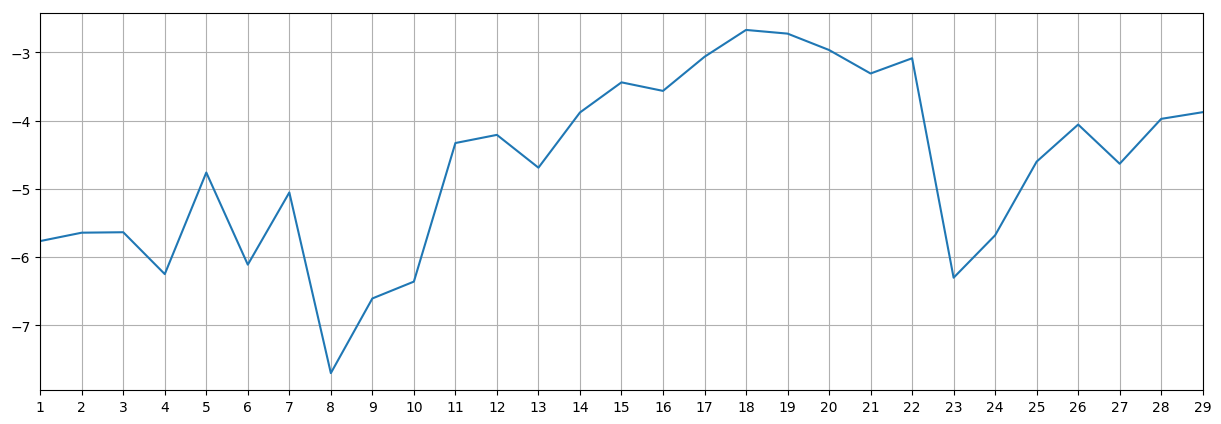

In [44]:
vals = analyse_for_best_shift(exp_detrended, list(range(1,30)));

ADF Statistic: -7.699307
p-value: 0.000000
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576


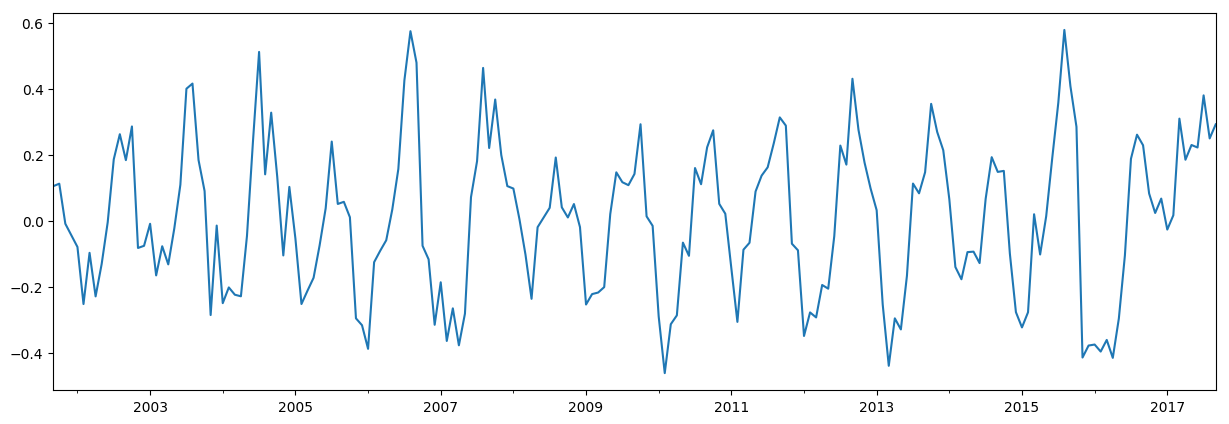

In [45]:
exp_diff_residials = exp_detrended.diff(8)[8:]
small_stat_test(exp_diff_residials)
exp_diff_residials.plot()

In [46]:
%%capture 
li = []
for i in range(1,20):
    aprox = exp_approximation(ts_log_dif_8, halflife=i, plot=False)
    resid = (ts_log_dif_8 - aprox)
    resid.dropna(inplace=True)
    li.append(adfuller(resid)[0])
    plt.show()
    plt.plot(resid)
    small_stat_test(resid)

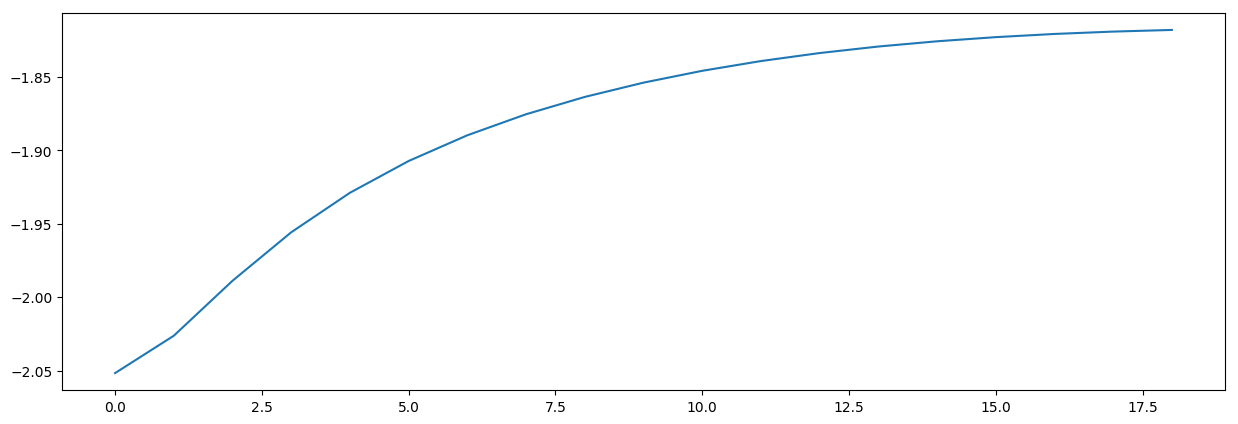

In [47]:
plt.plot(li)

# As we can see, manually we can`t achive same efficiency, allso in case of `seasonal decompose` we have clear  stationary seasonal data, which we do not need predict.
# I think that use of differencing approach can be considered, as in the end we'll obtain our initial data much easier


decomposed
ADF Statistic: -5.357705
p-value: 0.000004
Critical Values:
	5%: -2.878
	1%: -3.467
	10%: -2.575

8-diff
ADF Statistic: -6.398222
p-value: 0.000000
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576

exp-residials
ADF Statistic: -7.699307
p-value: 0.000000
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576



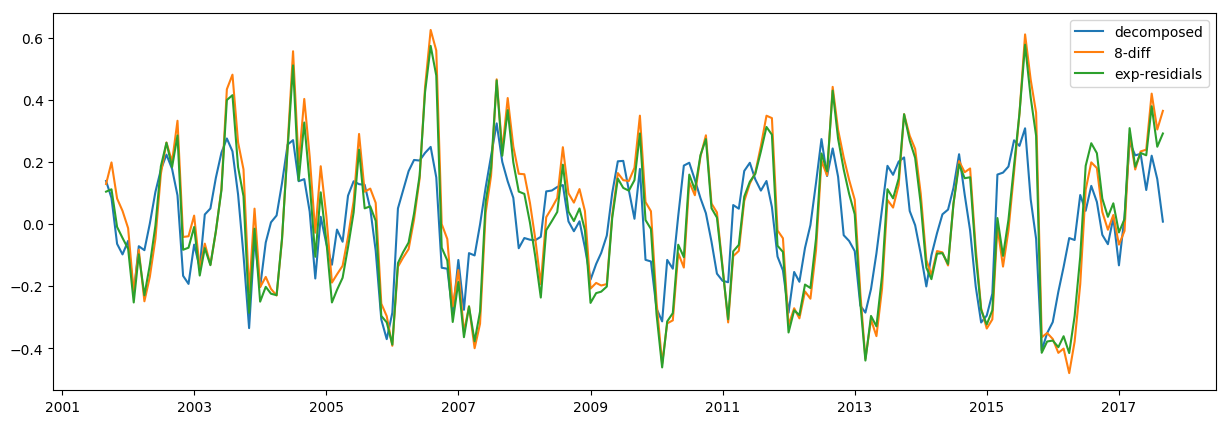

In [48]:
dec, = plt.plot(ts_log_decomposed_residuals)
dif8, = plt.plot(ts_log_dif_8)
dif_exp, = plt.plot(exp_diff_residials)

plt.legend([dec,dif8, dif_exp],['decomposed', '8-diff', 'exp-residials'])

print()
print('decomposed')
small_stat_test(ts_log_decomposed_residuals)
print()
print('8-diff')
small_stat_test(ts_log_dif_8)
print()
print('exp-residials')
small_stat_test(exp_diff_residials)
print()


### Here we obtained three realatively similar representation. 
## On the one hand, decomposed data have stationary seasonal series, but on the other: 8-diff is only one component. Allao exp-diff-residuals has known trend. 
# Nevertheless all examples has 1-st and 2-d has trends which are needed to explain separately.


# 4) Тренування та валідація MA, AR, ARMA, ARIMA моделей;

In [49]:
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARIMAResults, ARMAResults
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [50]:
def decompose_train_valid(ts, timestamp):
    ts_train = ts[ts.index < timestamp]
    ts_valid = ts[ts.index >= timestamp]
    return ts_train, ts_valid

In [51]:
def split_last_period(training_data, period_len):
    training_border = training_data.index[-period_len]
    print ("Data span from: [{}]  to: [{}]".format(training_data.index[0], training_data.index[-1]))
    print ("Split_border [{}]  ".format(training_border))
    train, valid = decompose_train_valid(training_data, timestamp=training_border)
    return train, valid

In [52]:
def RMSE(data, fitted_val):
    dif_row = fitted_val - data
    dif_row.dropna(inplace = True)
    return np.sqrt(sum((dif_row)**2))

In [53]:
def plot_ARIMA(data, prediction, col_data='blue', col_pred='red'):
    plt.plot(data, color = col_data)
    plt.plot(prediction, color=col_pred)
    print('RMSE: %.4f'% RMSE(data,prediction ))
#     plt.title('RMSE: %.4f'% RMSE(data,prediction ) )

In [54]:
def train_valid_ARIMA(train, valid, p_d_q):
    
    
    model = ARIMA (train, order = p_d_q )
    fitted_model = model.fit(disp=-1)
    
    train_predicted = fitted_model.fittedvalues
    train_predicted = pd.Series(index = train.index, data = train_predicted)
    
    valid_predicted = fitted_model.forecast(len(valid))[0]
    valid_predicted = pd.Series(index = valid.index , data = valid_predicted)
    
    return fitted_model, train_predicted, valid_predicted

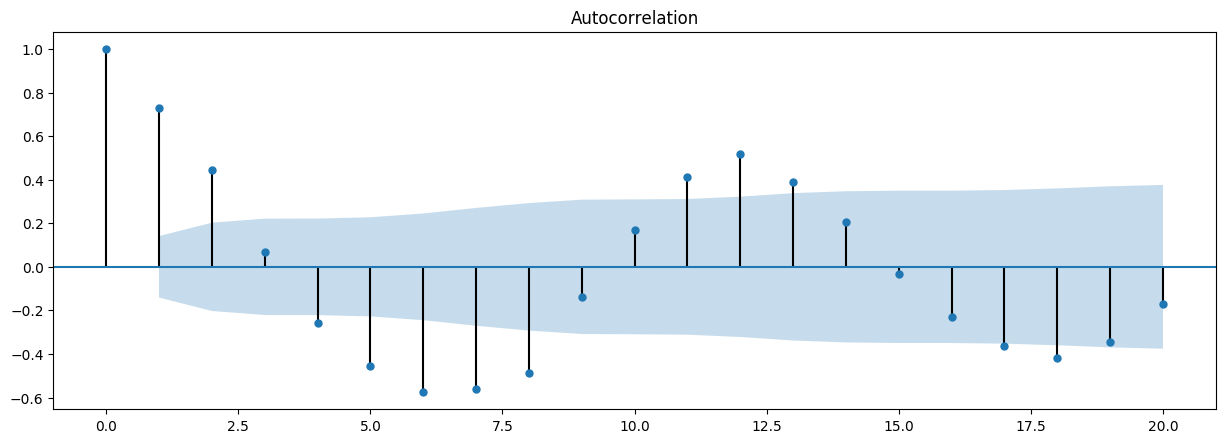

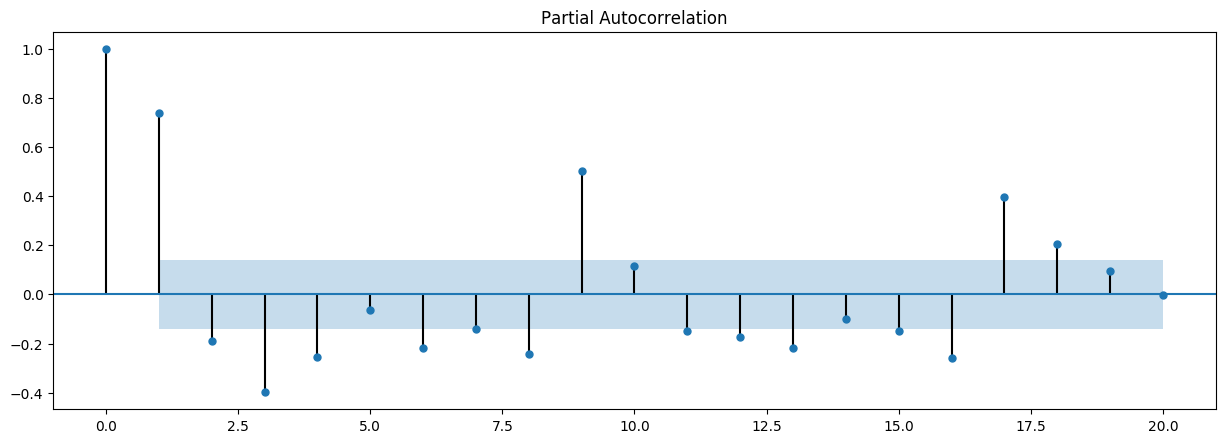

In [55]:
plot_acf(ts_log_dif_8, lags = 20 )
plot_pacf(ts_log_dif_8, lags = 20, method='ols')
plt.show()

# P = 2-3 or 9+..., Q = 2 or 5

# MA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.7266
RMSE: 1.3749


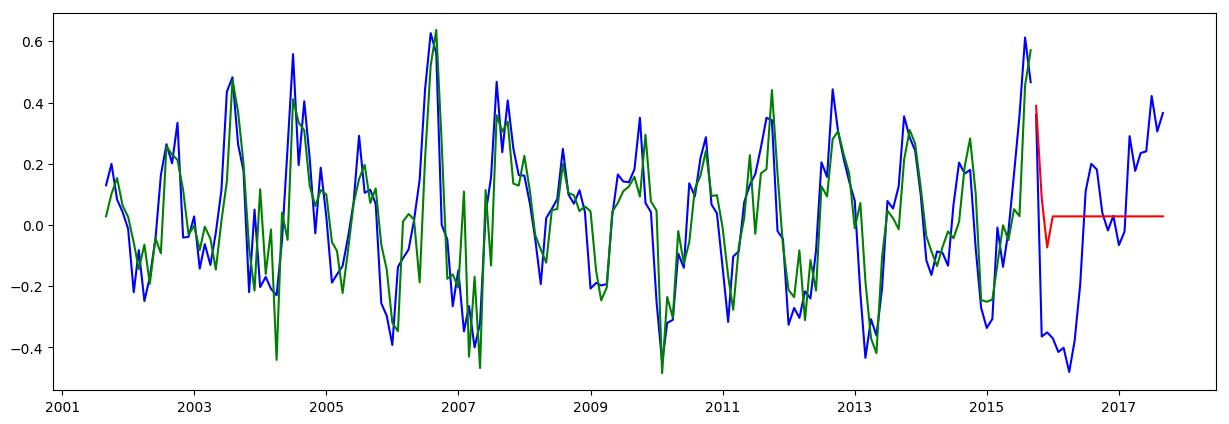

In [56]:
train, valid = split_last_period(ts_log_dif_8, 24)

# 2 - not converge, 5 - same as 2
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (0,0,3))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

# AR

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.8592
RMSE: 1.2222


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.1366


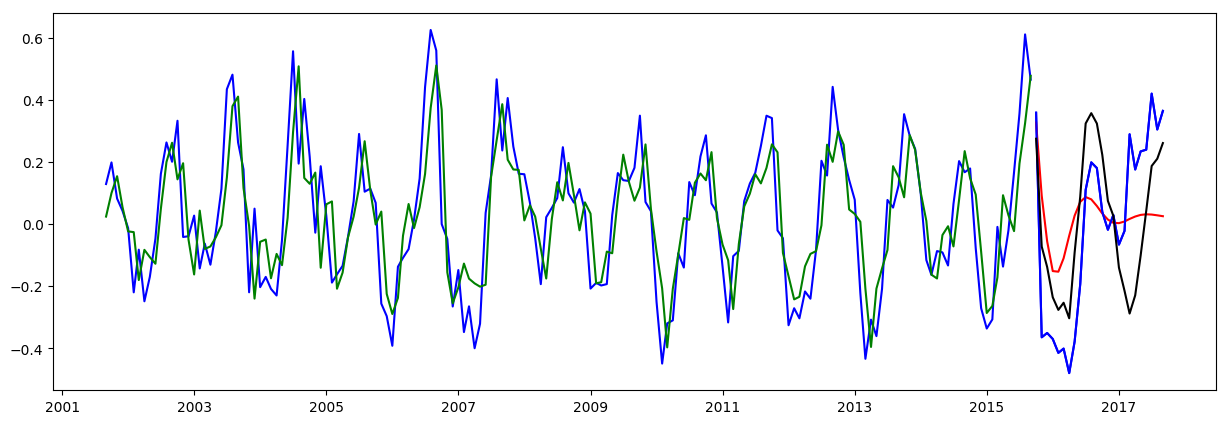

In [57]:
train, valid = split_last_period(ts_log_dif_8, 24)

# 2 - not converge, 5 - same as 2
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,0))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (9,0,0))
plot_ARIMA(valid, valid_pred, 'blue', 'black')


# ARMA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.8592
RMSE: 1.2222


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.1286


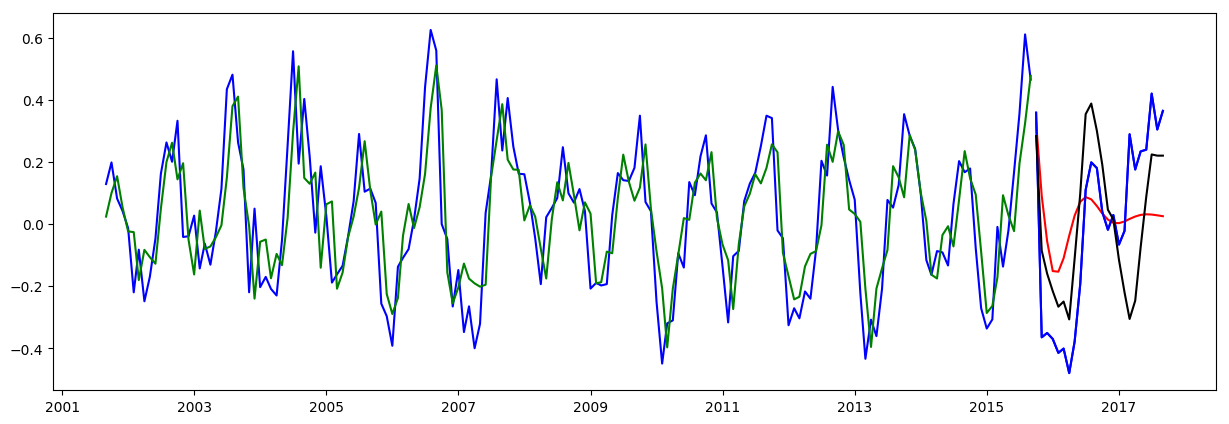

In [58]:
train, valid = split_last_period(ts_log_dif_8, 24)


model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,0)) 

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (9,0,3))
plot_ARIMA(valid, valid_pred, 'blue', 'black')


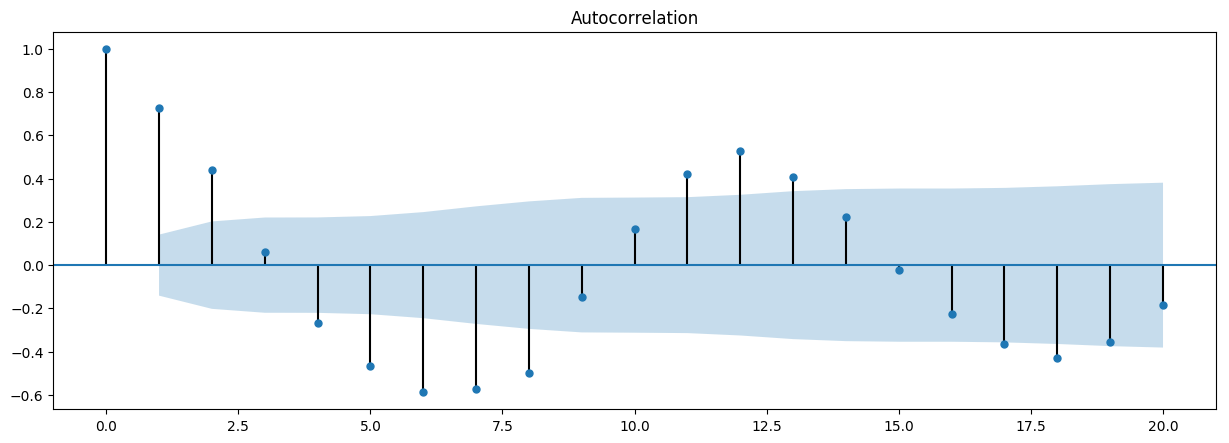

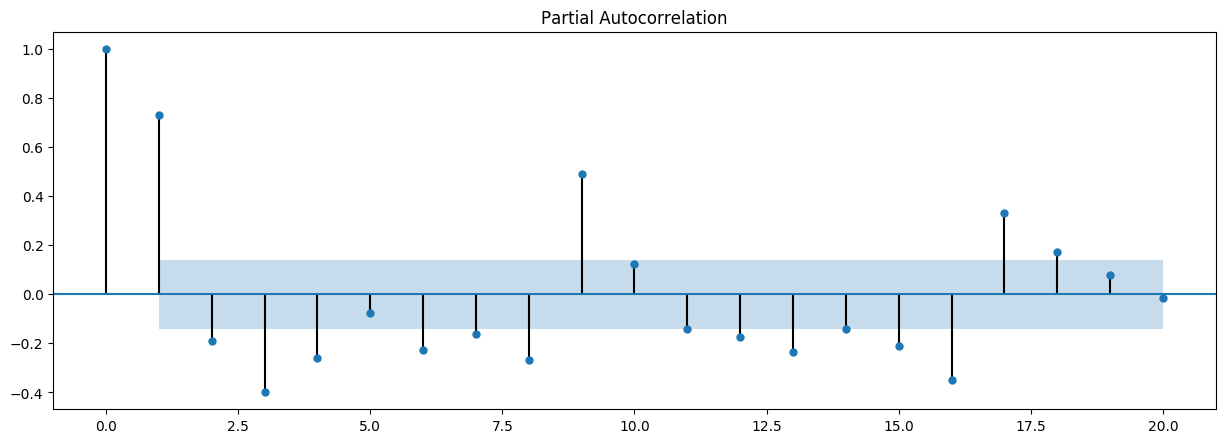

In [59]:
plot_acf(exp_diff_residials, lags = 20 )
plot_pacf(exp_diff_residials, lags = 20, method='ols')
plt.show()

# P = 2-3 or 7+, Q = 2 or 5

# MA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.6530
RMSE: 1.2896


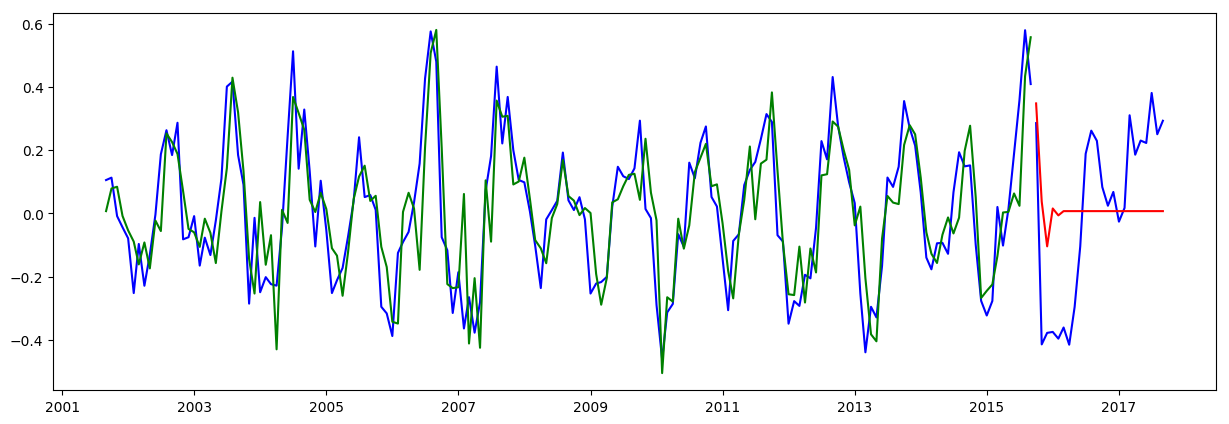

In [60]:
train, valid = split_last_period(exp_diff_residials, 24)

# 2 - not converge, 5 - same as 2
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (0,0,5))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

# AR

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.7924
RMSE: 1.1479


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.0800


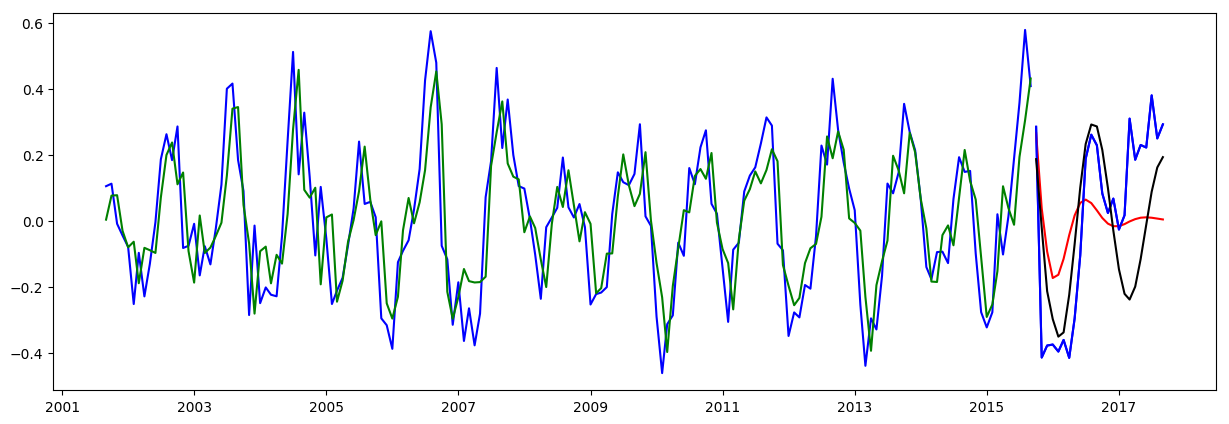

In [61]:
train, valid = split_last_period(exp_diff_residials, 24)

# 2 - not converge, 5 - same as 2
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,0))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (7,0,0))
plot_ARIMA(valid, valid_pred, 'blue', 'black')


# ARMA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.6240
RMSE: 1.0760


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE: 1.0322


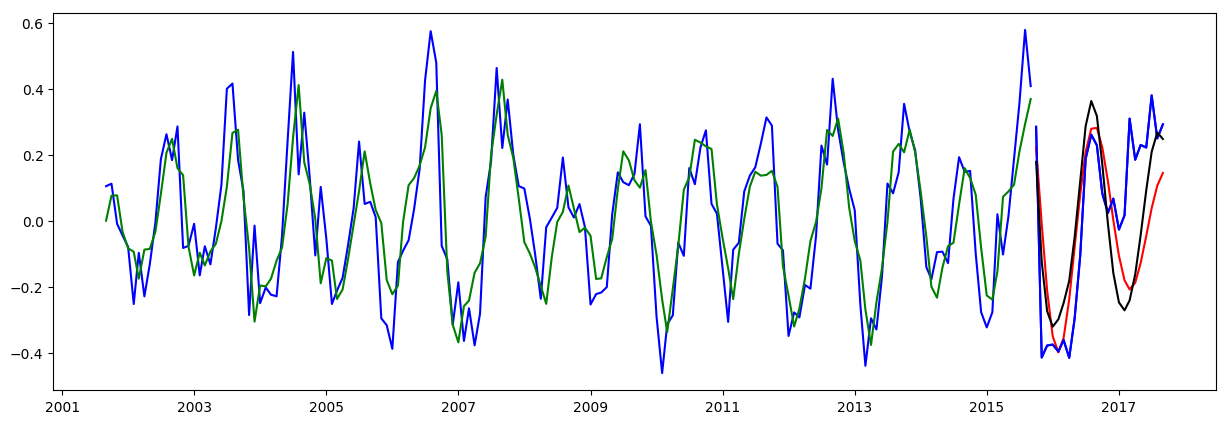

In [62]:
train, valid = split_last_period(exp_diff_residials, 24)


model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,2)) 

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (7,0,3))
plot_ARIMA(valid, valid_pred, 'blue', 'black')


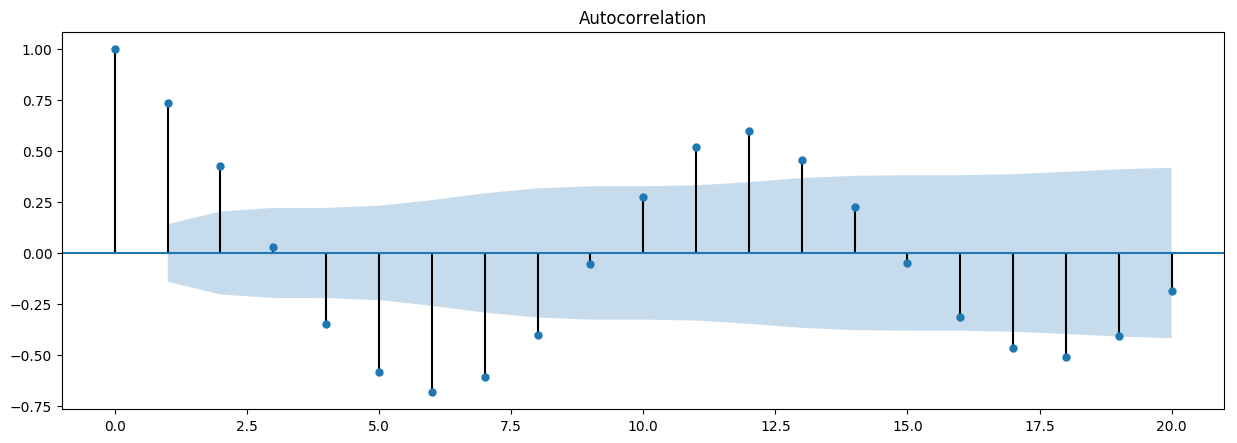

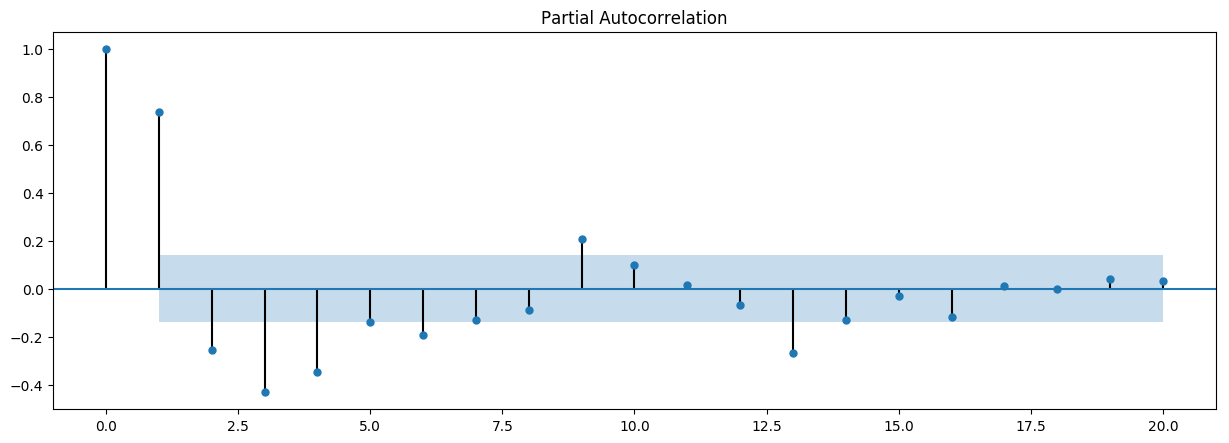

In [63]:
plot_acf(ts_log_decomposed_residuals, lags = 20 )
plot_pacf(ts_log_decomposed_residuals, lags = 20, method='ols')
plt.show()

# P = 2-3 or 7+, Q = 5

# MA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.3393
RMSE: 0.7551


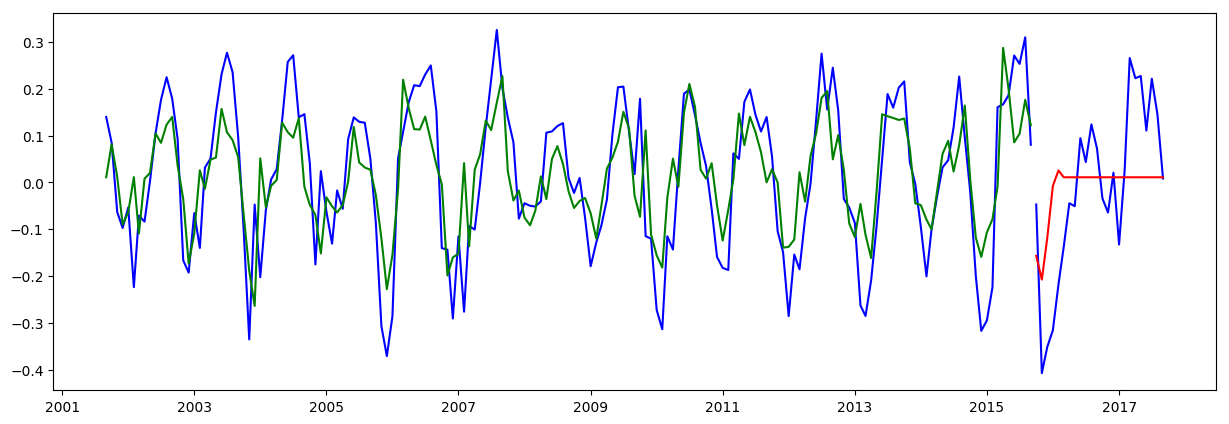

In [64]:
train, valid = split_last_period(ts_log_decomposed_residuals, 24)

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (0,0,5))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

# AR

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.2354
RMSE: 0.7072


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 0.6500


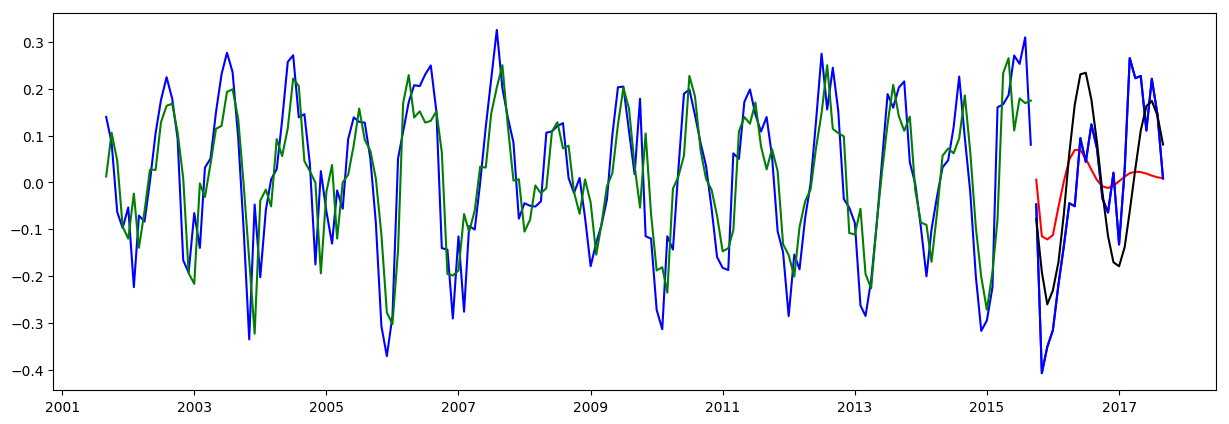

In [65]:
train, valid = split_last_period(ts_log_decomposed_residuals, 24)

# 2 - not converge, 5 - same as 2
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,0))

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (7,0,0))
plot_ARIMA(valid, valid_pred, 'blue', 'black')


# ARMA

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.0910
RMSE: 0.6611


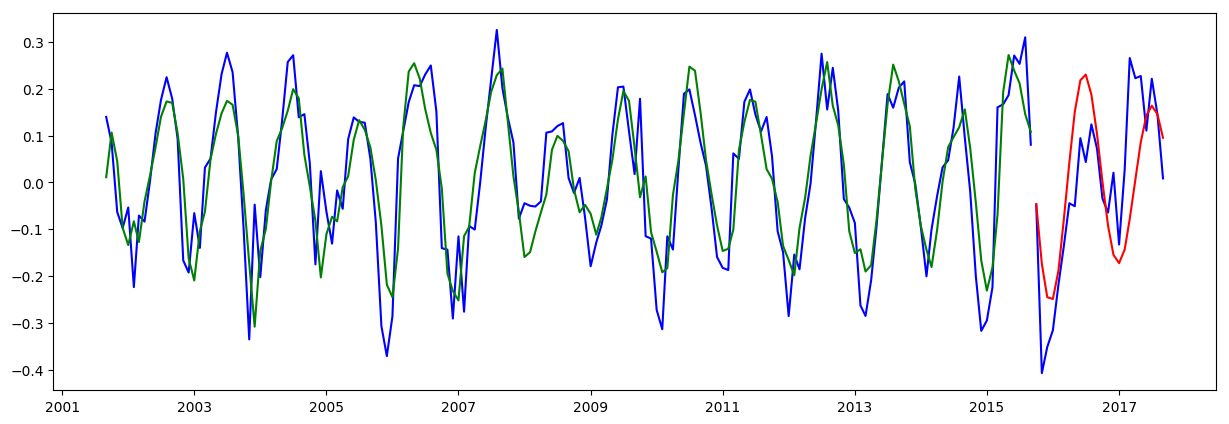

In [66]:
train, valid = split_last_period(ts_log_decomposed_residuals, 24)


model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,2)) 

plot_ARIMA(train, tr_pred, 'blue', 'green')

plot_ARIMA(valid, valid_pred, 'blue', 'red')

# model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (9,0,3)) # converges but overfitt
# plot_ARIMA(valid, valid_pred, 'blue', 'black')


# 5) Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

In [67]:
validation_period_len = 24 # two years


#### failed to find ready-to-use methods, written tools:

In [68]:
def invert_diff_periods (diff, first_period):
    """first_period
    [diff] Series (obtained as a result of <series_object>.diff(periods=k))
    [first_period] Series - original k-first beggining before .diff(k) occured  
    """
    diff.dropna(inplace = True)
    refined = first_period.append (diff)
    period_len = len (first_period)
    for i in range(len(refined) - period_len):
        refined[i+period_len] += refined[i]
    return refined

In [69]:
def my_MSE(a,b):
    dif = (a - b).dropna()
    MSE = np.sqrt(np.sum((a - b).dropna() ** 2))
    return MSE 

In [70]:
from scipy.stats import norm
#TODO make real feat with gaussian
def plot_errors(model_errors):
    mean = np.mean(model_errors)
    std = np.std(model_errors)
    print ("Mean = [{}] STD = [{}]".format(mean, std))
    x_axis = np.arange(-3* std, 3 * std, 0.001)
    plt.figure()
    present, = plt.plot(x_axis, norm.pdf(x_axis,mean,std) * 500)
    ideal, = plt.plot(x_axis, norm.pdf(x_axis,0,std) *  500)
    n, bins, patches = plt.hist(model_errors, 50, facecolor='g', alpha=0.24)
    plt.legend([present, ideal], ['current errors','ideal random errors'])
    plt.grid(True)
    plt.show()

#       Model on simple Differences

In [71]:
train, valid = split_last_period(ts_log_dif_8, validation_period_len)

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.9810
RMSE: 1.2297
nan


<class 'statsmodels.iolib.table.SimpleTable'>

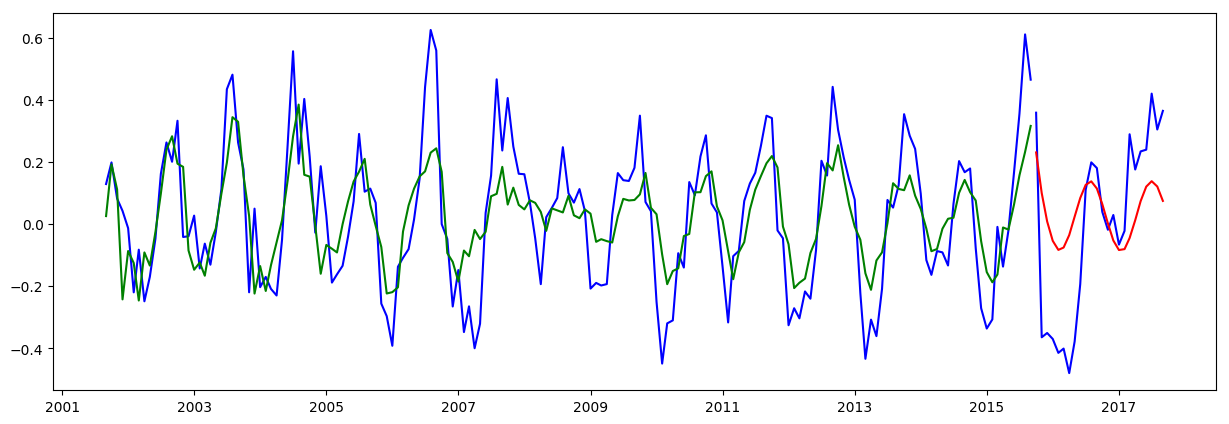

In [72]:
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,2)) 
plot_ARIMA(train, tr_pred, 'blue', 'green')
plot_ARIMA(valid, valid_pred, 'blue', 'red')

print (model.aic)
model.summary().tables[1]

RMSE: 290.2823
RMSE: 238.9715


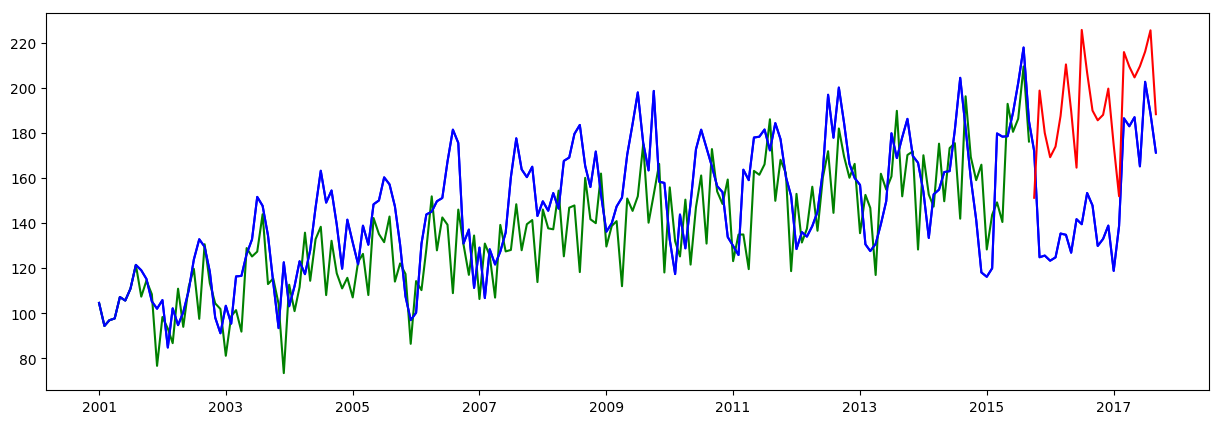

RMSE: 238.9715


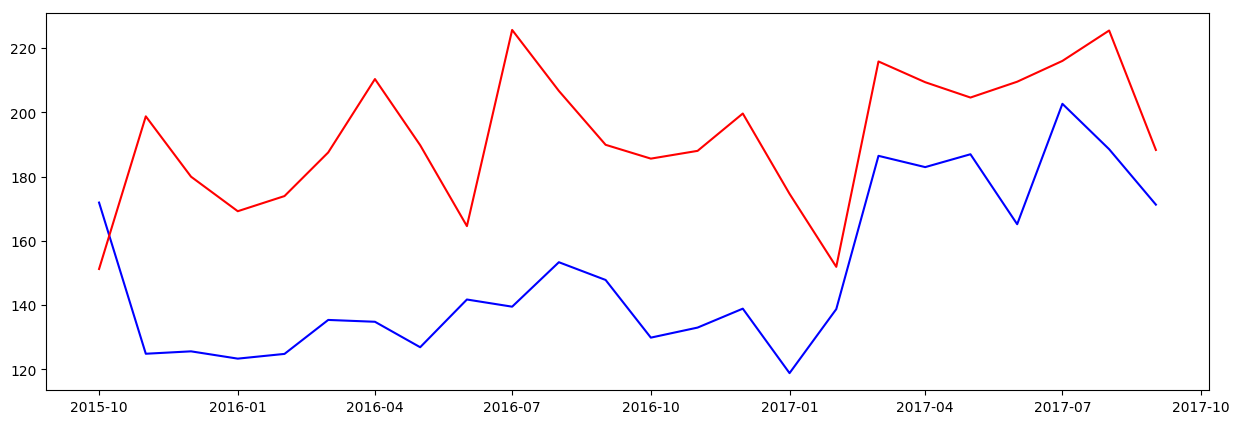

In [73]:
restored_train = np.exp(invert_diff_periods(tr_pred,
                                               first_period=ts_log[:SEASON_Hypothesis]))

restored_valid = np.exp(invert_diff_periods(train.append(valid_pred),
                                               first_period=ts_log[:SEASON_Hypothesis]))

plot_ARIMA(raw_ts, restored_train, 'blue', 'green')
plot_ARIMA(raw_ts, restored_valid[-validation_period_len:], 'blue', 'red')

plt.show()
plot_ARIMA(raw_ts[-validation_period_len:], restored_valid[-validation_period_len:], 'blue', 'red')

Mean = [9.628087861751258] STD = [19.579751163968773]


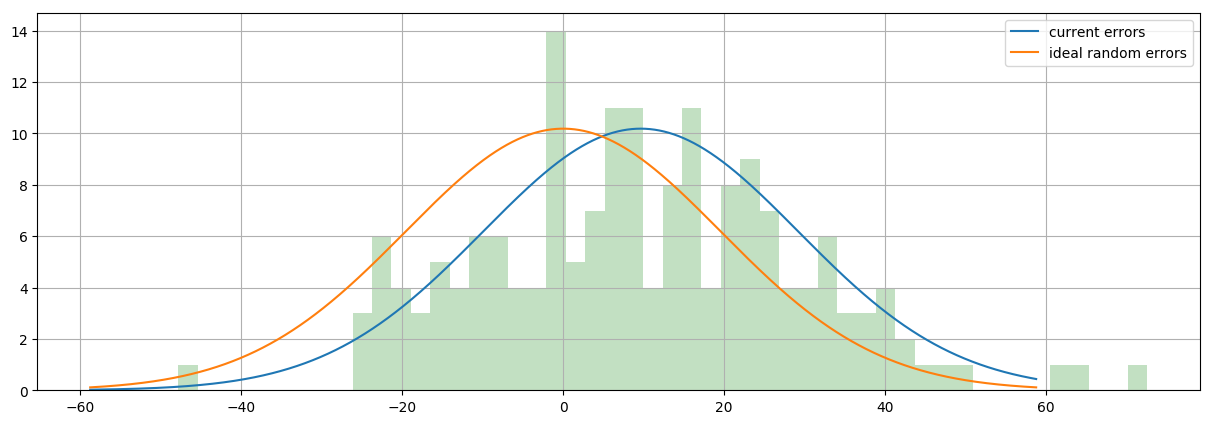

Mean = [-42.64079041579331] STD = [23.69044855780541]


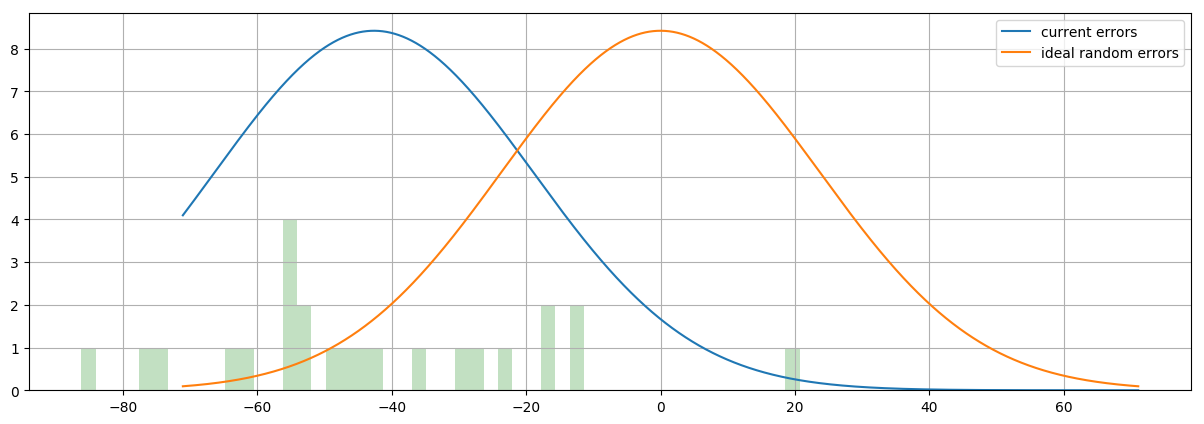

In [74]:
#train
plot_errors ( (raw_ts - restored_train).dropna() )
#valid
plot_errors( raw_ts[-validation_period_len:] - restored_valid[-validation_period_len:] )

#       Model on EXP-detrended Differences

In [75]:
train, valid = split_last_period(exp_diff_residials, validation_period_len)

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.6240
RMSE: 1.0760
-207.77059973215245


<class 'statsmodels.iolib.table.SimpleTable'>

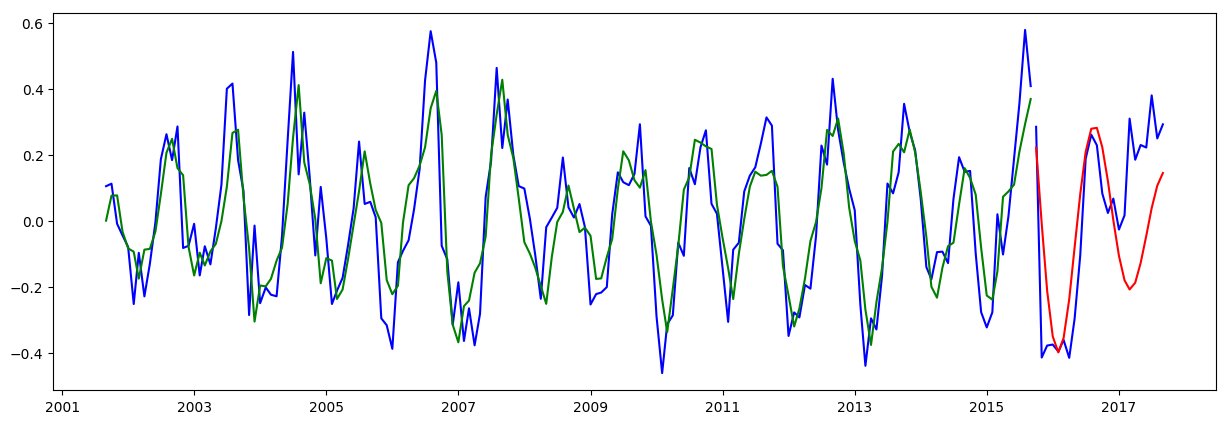

In [76]:
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,2)) 
plot_ARIMA(train, tr_pred, 'blue', 'green')
plot_ARIMA(valid, valid_pred, 'blue', 'red')

print (model.aic)
model.summary().tables[1]


RMSE: 205.2709
RMSE: 141.4430


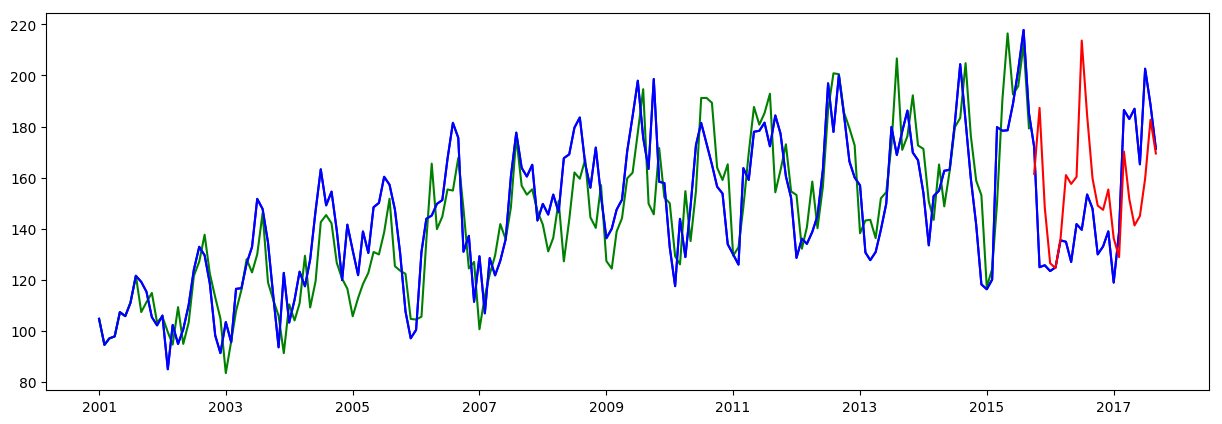

RMSE: 141.4430


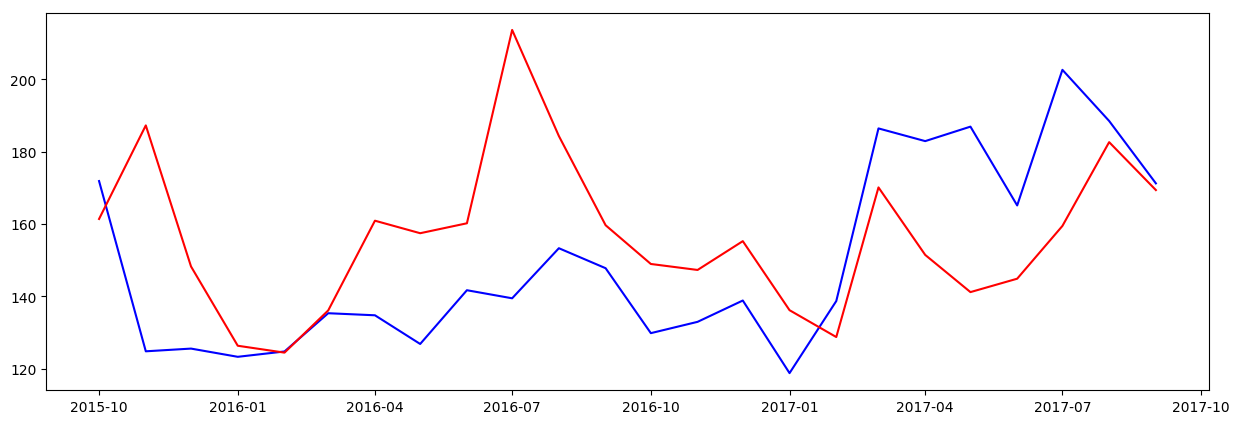

In [77]:
restored_train = np.exp(invert_diff_periods(tr_pred,
                                               first_period=exp_detrended[:SEASON_Hypothesis]) + \
                       expwighted_avg) #to restore trend 

restored_valid = np.exp(invert_diff_periods(train.append(valid_pred),
                                               first_period=exp_detrended[:SEASON_Hypothesis]) + \
                       expwighted_avg)

plot_ARIMA(raw_ts, restored_train, 'blue', 'green')
plot_ARIMA(raw_ts, restored_valid[-validation_period_len:], 'blue', 'red')

plt.show()
plot_ARIMA(raw_ts[-validation_period_len:], restored_valid[-validation_period_len:], 'blue', 'red')

Mean = [2.062006082316246] STD = [15.29069687890419]


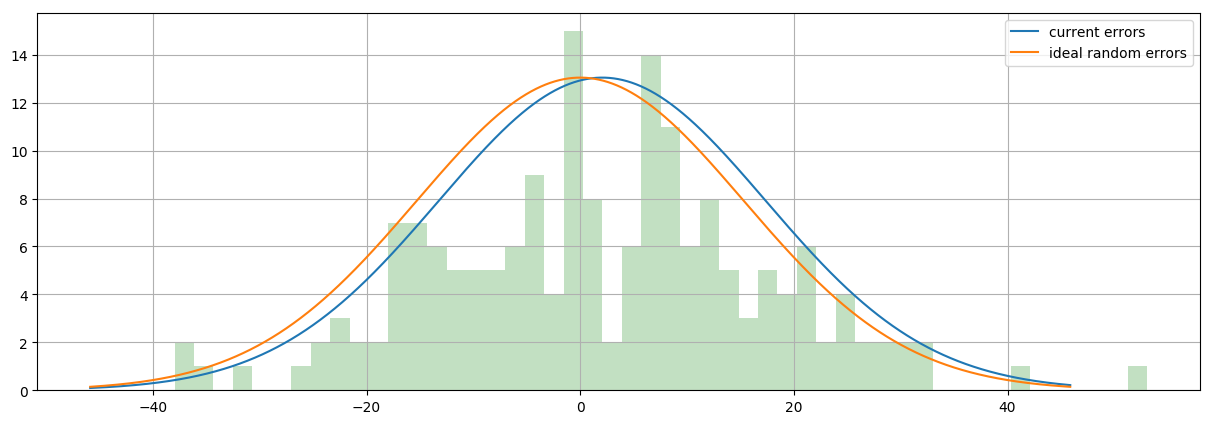

Mean = [-6.80009710894448] STD = [28.059704837865553]


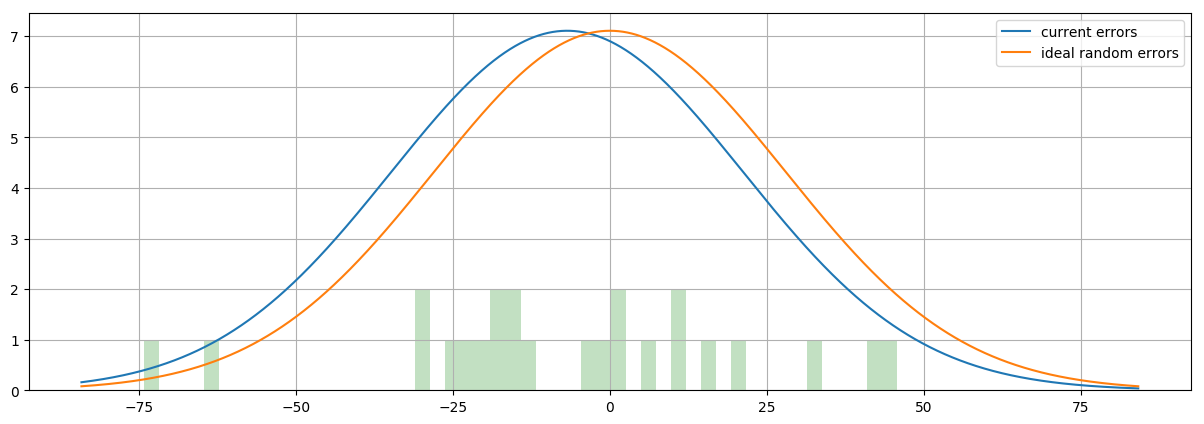

In [78]:
#train
plot_errors ( (raw_ts - restored_train).dropna() )
#valid
plot_errors( raw_ts[-validation_period_len:] - restored_valid[-validation_period_len:] )

## Iterative approach predictor 

In [79]:
history = list(train.copy())
iterative_validation_forecast = list()
for t in range(len(valid)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    iterative_validation_forecast.append(yhat)
    obs = valid[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.222252, expected=0.285184
predicted=0.025928, expected=-0.414454
predicted=-0.424656, expected=-0.378074
predicted=-0.506253, expected=-0.375023
predicted=-0.348650, expected=-0.396297
predicted=-0.250836, expected=-0.361054
predicted=-0.148424, expected=-0.415452
predicted=-0.105327, expected=-0.296037
predicted=-0.003847, expected=-0.104632
predicted=0.160878, expected=0.188208
predicted=0.357951, expected=0.261292
predicted=0.397246, expected=0.229207
predicted=0.294978, expected=0.082919
predicted=0.115266, expected=0.023944
predicted=0.002274, expected=0.067520
predicted=0.011753, expected=-0.026368
predicted=-0.038432, expected=0.016915
predicted=-0.031364, expected=0.309969
predicted=0.159554, expected=0.185329
predicted=0.111477, expected=0.230003
predicted=0.061003, expected=0.222385
predicted=0.044857, expected=0.380495
predicted=0.112730, expected=0.249964
predicted=0.037426, expected=0.292653


In [80]:
iterative_valid_pred = pd.Series(index=valid.index, data=iterative_validation_forecast[0])
combined_data_forecast_with_iterative = train.append(iterative_valid_pred)

RMSE: 658.8094


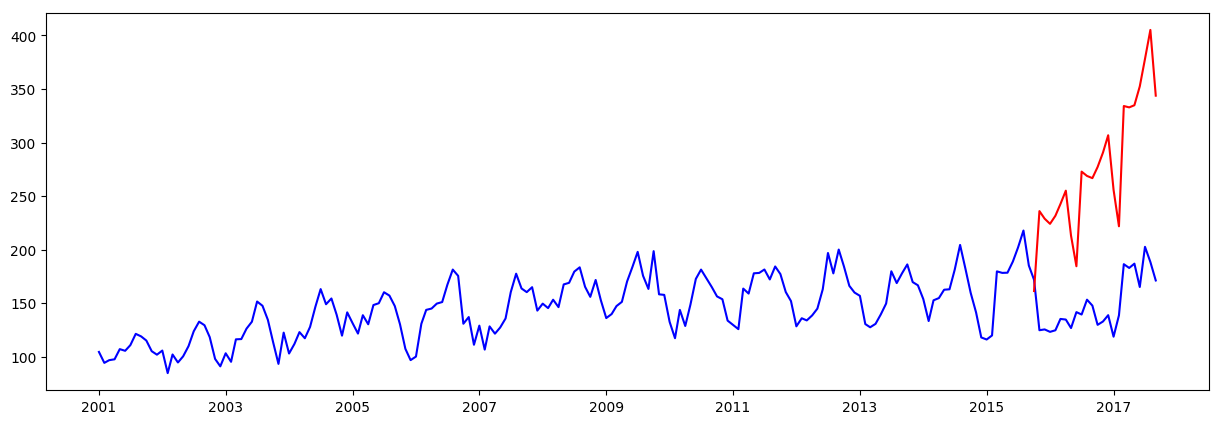

RMSE: 658.8094


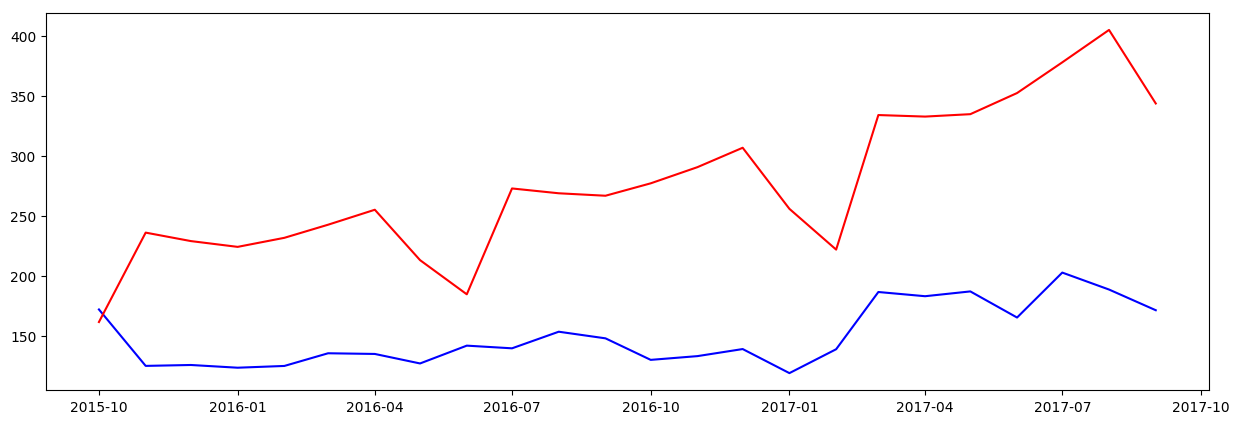

In [81]:

restored_valid_iterative = np.exp(invert_diff_periods(combined_data_forecast_with_iterative,
                                               first_period=exp_detrended[:SEASON_Hypothesis]) + \
                       expwighted_avg)

plot_ARIMA(raw_ts, restored_valid_iterative[-validation_period_len:], 'blue', 'red')

plt.show()
plot_ARIMA(raw_ts[-validation_period_len:], restored_valid_iterative[-validation_period_len:], 'blue', 'red')


Mean = [-126.05446663362868] STD = [46.84918447935591]


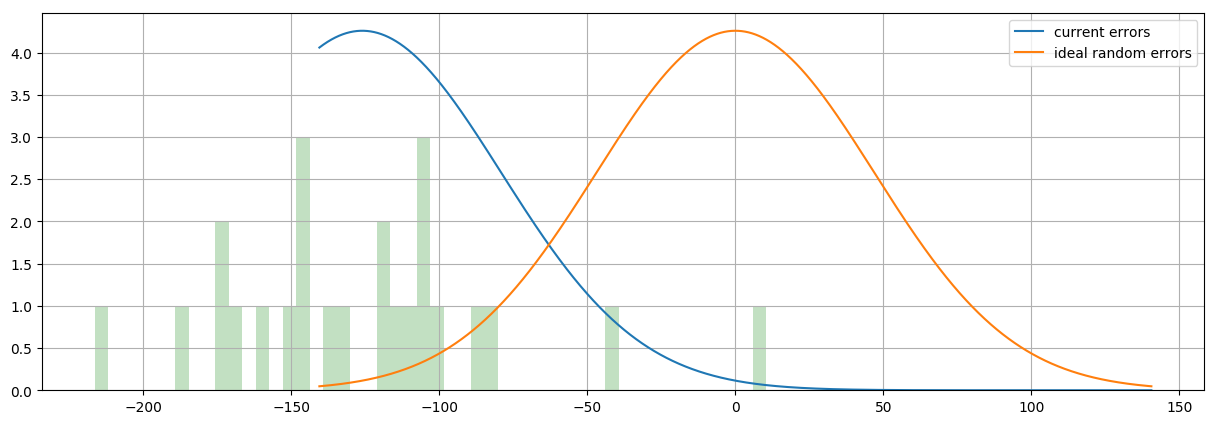

In [82]:
plot_errors( (raw_ts[-validation_period_len:]- restored_valid_iterative[-validation_period_len:]).dropna() )

# MODEL ON DECOMPOSED RESIDUALS

In [83]:
validation_period = 12

## P1) Residuals

In [84]:
train, valid = split_last_period(ts_log_decomposed_residuals, validation_period_len)

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 1.0367
RMSE: 0.6429
-346.9868189631813


<class 'statsmodels.iolib.table.SimpleTable'>

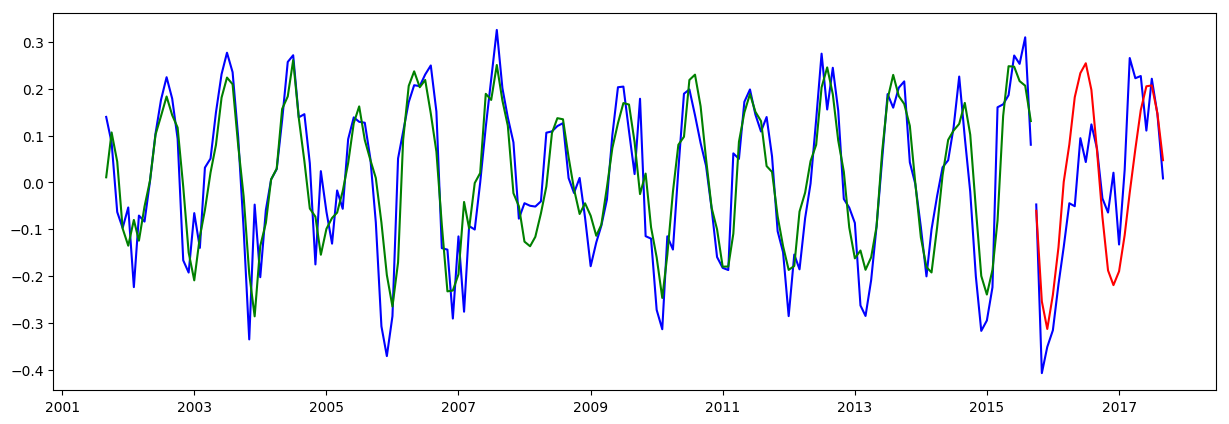

In [85]:
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (9,0,3)) 
plot_ARIMA(train, tr_pred, 'blue', 'green')
plot_ARIMA(valid, valid_pred, 'blue', 'red')

resid_tr_pred= tr_pred.copy()
resid_valid_pred=valid_pred.copy()

print (model.aic)
model.summary().tables[1]

RMSE: 146.6393
RMSE: 94.7066


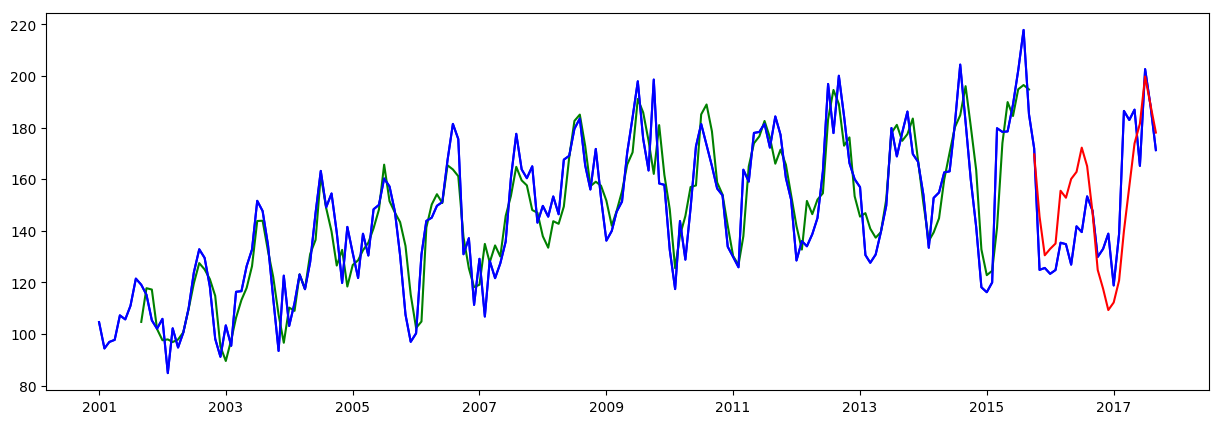

RMSE: 94.7066


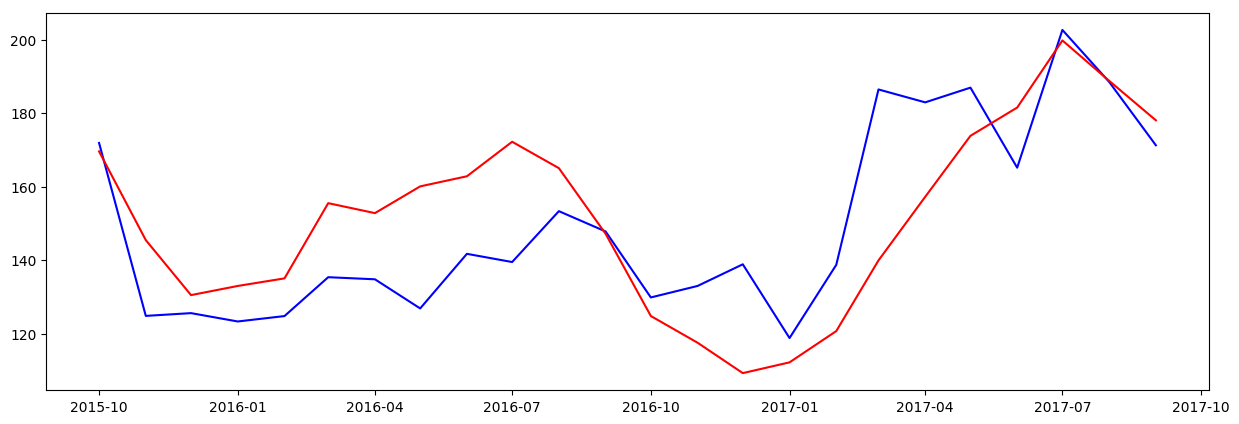

In [86]:
#here we use training data to be sure that errors we see came from this part of model
restored_train = np.exp( tr_pred\
                        .add(ts_log_decomposed_trend)\
                        .add(ts_log_decomposed_seasonal)\
                        .dropna() )

restored_valid = np.exp( valid_pred\
                        .add(ts_log_decomposed_trend)\
                        .add(ts_log_decomposed_seasonal)\
                        .dropna() )

plot_ARIMA(raw_ts, restored_train, 'blue', 'green')
plot_ARIMA(raw_ts, restored_valid[-validation_period_len:], 'blue', 'red')

plt.show()
plot_ARIMA(raw_ts[-validation_period_len:], restored_valid[-validation_period_len:], 'blue', 'red')


Mean = [0.28580473073780294] STD = [11.276325594475045]


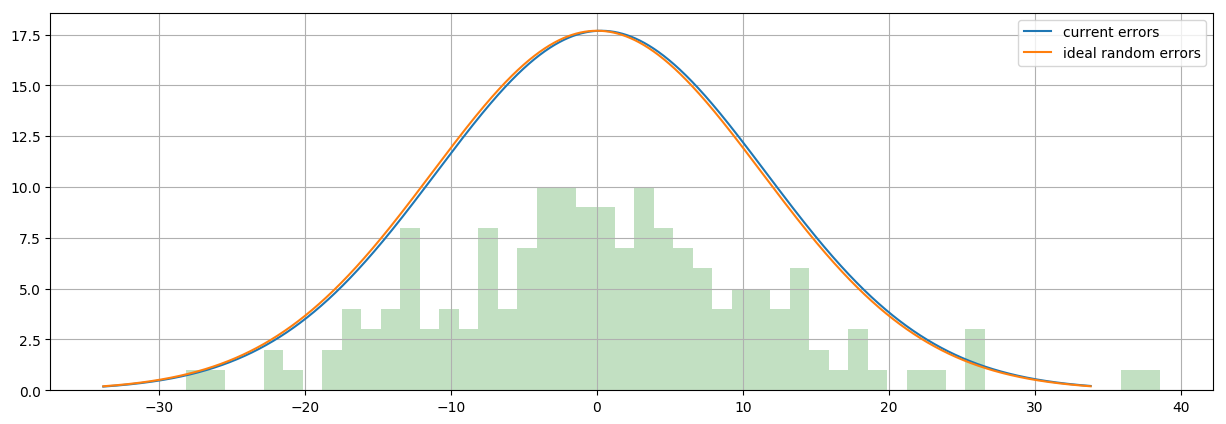

Mean = [-1.6629871714813251] STD = [19.260245105376566]


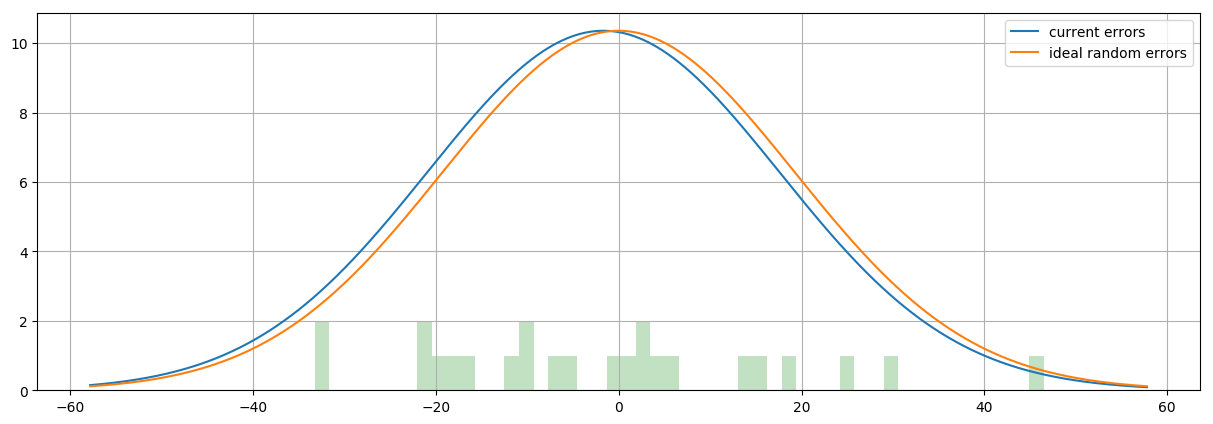

In [87]:
#train
plot_errors ( (raw_ts - restored_train).dropna() )
#valid
plot_errors( raw_ts[-validation_period_len:] - restored_valid[-validation_period_len:] )

## P2) Seasonality

Data span from: [2001-01-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


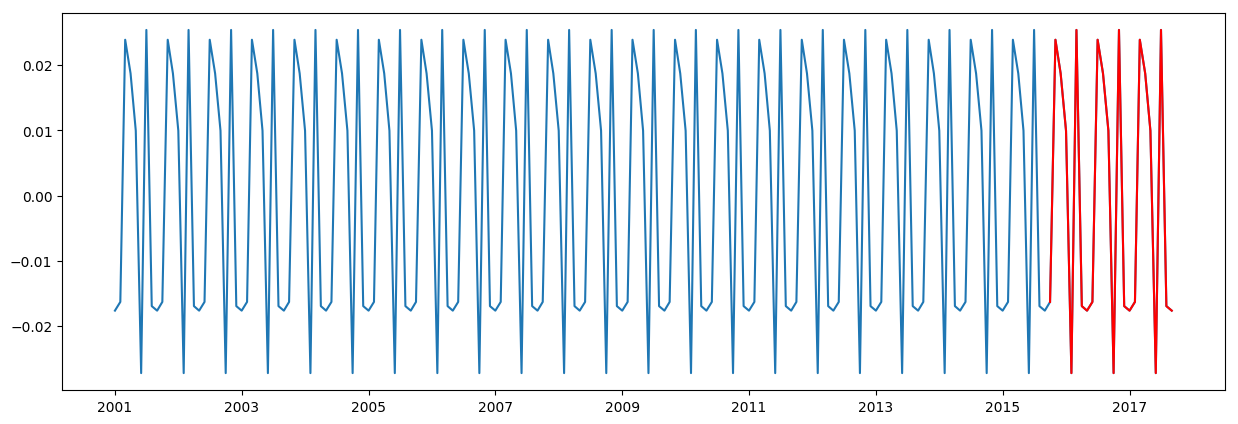

MSE : [0.0]


In [88]:
train, valid = split_last_period(ts_log_decomposed_seasonal, 24)

prediction = pd.Series(index = valid.index, data=train.data[-len(valid):] )


seasonal_tr_pred= train.copy()
seasonal_valid_pred=prediction.copy()

plt.plot(train.append(valid))
plt.plot(prediction, color='red')
plt.show()
print("MSE : [{}]".format(my_MSE(valid, prediction )) ) # <=== we've done all good


## P2) Trend

In [89]:
train, valid = split_last_period(ts_log_decomposed_trend, validation_period_len)

Data span from: [2001-09-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2015-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE: 0.2740
RMSE: 0.7533
-1112.9214408915843


<class 'statsmodels.iolib.table.SimpleTable'>

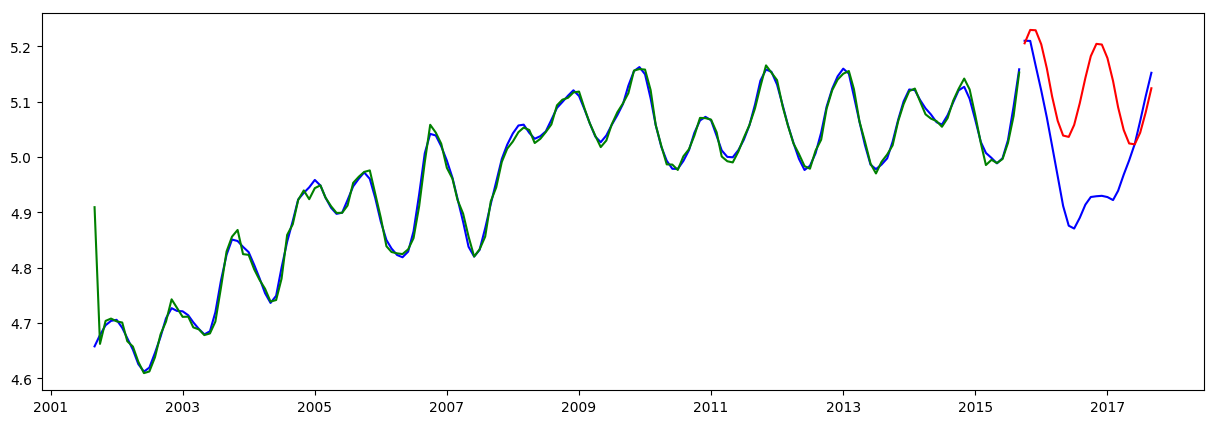

In [90]:
model, tr_pred, valid_pred = train_valid_ARIMA(train, valid, (3,0,3)) 
plot_ARIMA(train, tr_pred, 'blue', 'green')
plot_ARIMA(valid, valid_pred, 'blue', 'red')

trend_tr_pred= tr_pred.copy()
trend_valid_pred=valid_pred.copy()

print (model.aic)
model.summary().tables[1]

## here we use training data to be sure that errors we see came from this part of model

RMSE: 37.7226
RMSE: 117.2686


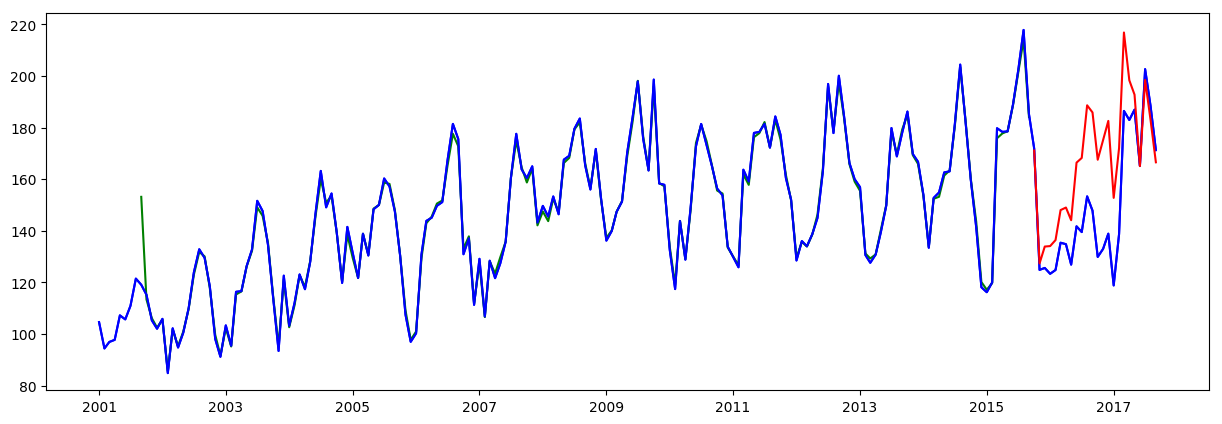

RMSE: 117.2686


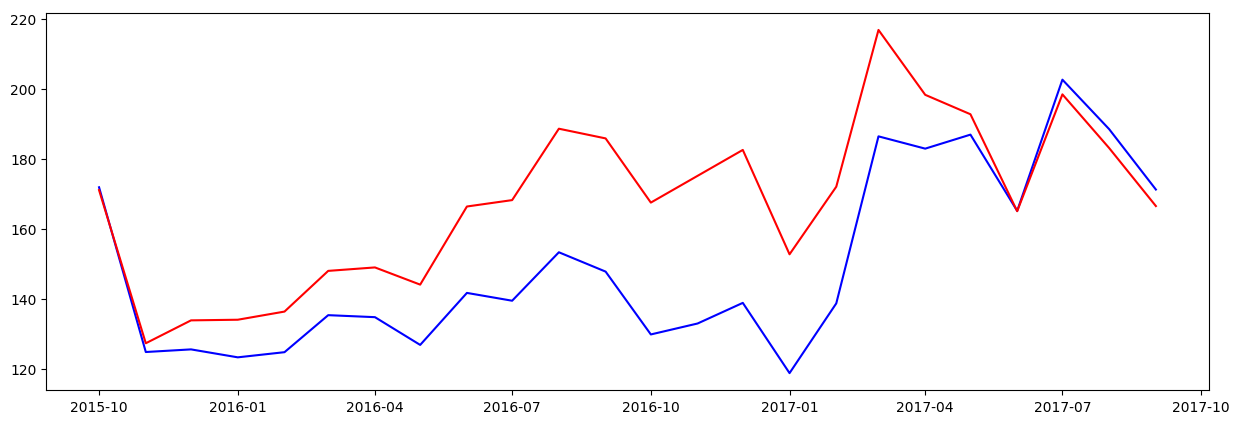

In [91]:
restored_train = np.exp( tr_pred\
                        .add(ts_log_decomposed_residuals)\
                        .add(ts_log_decomposed_seasonal)\
                        .dropna() )

restored_valid = np.exp( valid_pred\
                        .add(ts_log_decomposed_residuals)\
                        .add(ts_log_decomposed_seasonal)\
                        .dropna() )

plot_ARIMA(raw_ts, restored_train, 'blue', 'green')
plot_ARIMA(raw_ts, restored_valid[-validation_period_len:], 'blue', 'red')

plt.show()
plot_ARIMA(raw_ts[-validation_period_len:], restored_valid[-validation_period_len:], 'blue', 'red')


Mean = [-0.0003205555194603437] STD = [0.021073700511962532]


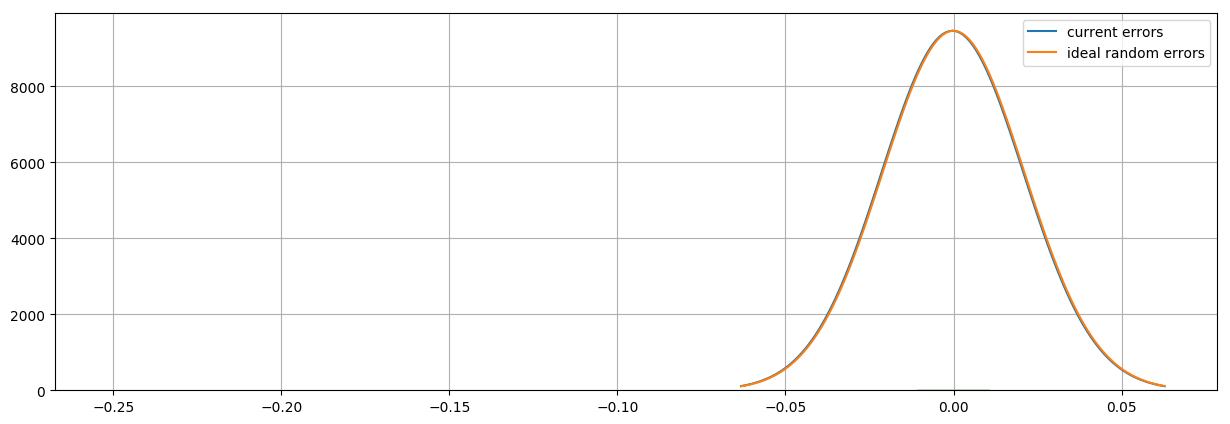

Mean = [-0.11695813886124747] STD = [0.09981687094617564]


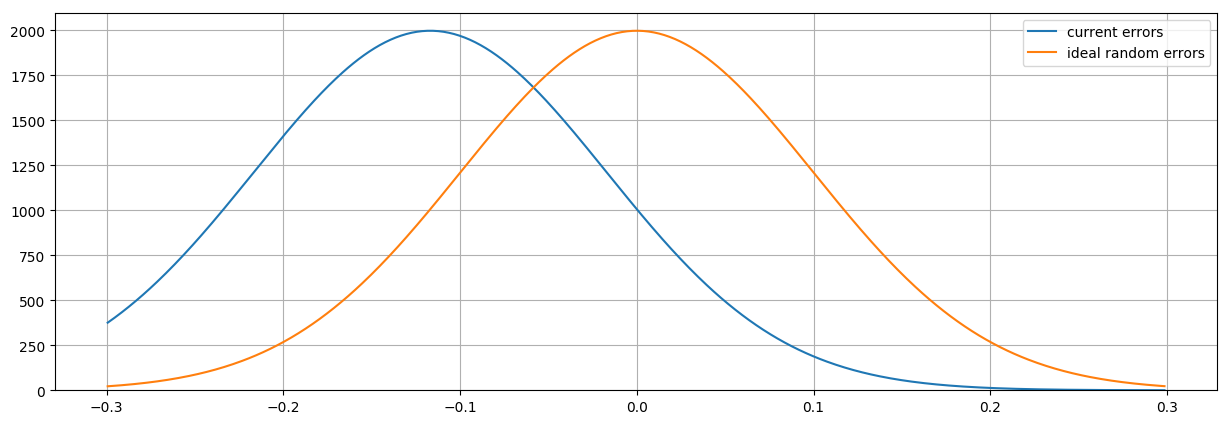

In [92]:
#  tr_pred, valid_pred
#train
plot_errors ( (ts_log_decomposed_trend - tr_pred).dropna() )
#valid
plot_errors( ts_log_decomposed_trend[-validation_period_len:] - valid_pred )

## we allso should check if differencing of our trend can give benefits. As it seems it can.

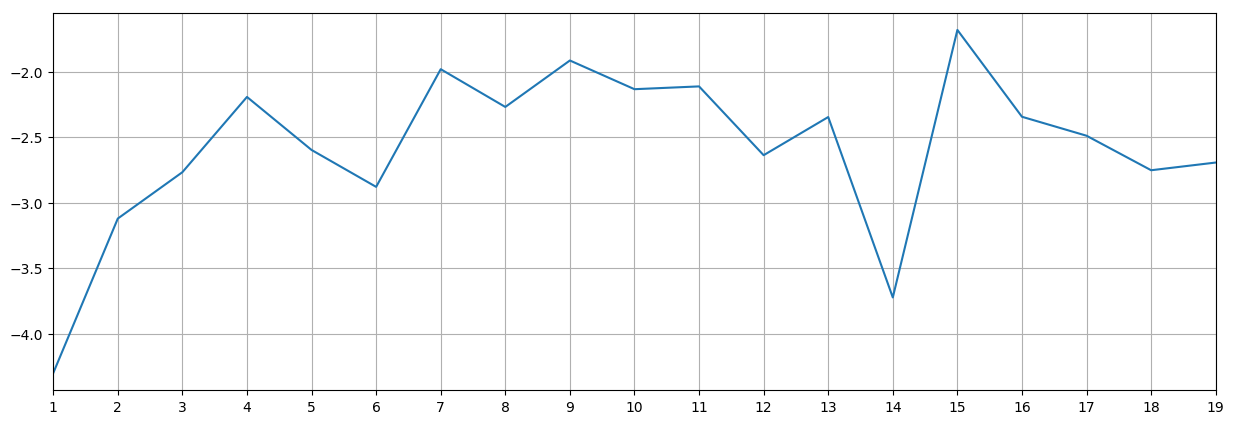

In [93]:
analyse_for_best_shift(ts_log_decomposed_trend, list(range(1,20)));

# Trend improvement

In [94]:
# exodata
D1 = DATA[0].copy()
masks = [
#     "Perak_Area_ma",
         "Perak_Area_npa",
#          "Perak_Area_rpa",
         "Perak_Area_ma_new",
         'Perak_Production',
         'Perak_Rainfall'
        ]
shifts =  [  8,9,10,11,12, 15,  18, 24]
for m in masks:
    for i in shifts:
        D1[ (m + "_{}").format(i) ] = DATA[0][m].shift(i)
        D1.fillna(method = 'backfill',  inplace = True)
D1 = D1.drop(
    [ 'Perak_Month', 'Perak_Time'  , "Perak_Area_ma",
         "Perak_Area_npa",
         "Perak_Area_rpa",
         "Perak_Area_ma_new",
         'Perak_Production',
         'Perak_Rainfall' ], axis=1)     
       
print(D1.columns)

Index(['Perak_Area_npa_8', 'Perak_Area_npa_9', 'Perak_Area_npa_10',
       'Perak_Area_npa_11', 'Perak_Area_npa_12', 'Perak_Area_npa_15',
       'Perak_Area_npa_18', 'Perak_Area_npa_24', 'Perak_Area_ma_new_8',
       'Perak_Area_ma_new_9', 'Perak_Area_ma_new_10', 'Perak_Area_ma_new_11',
       'Perak_Area_ma_new_12', 'Perak_Area_ma_new_15', 'Perak_Area_ma_new_18',
       'Perak_Area_ma_new_24', 'Perak_Production_8', 'Perak_Production_9',
       'Perak_Production_10', 'Perak_Production_11', 'Perak_Production_12',
       'Perak_Production_15', 'Perak_Production_18', 'Perak_Production_24',
       'Perak_Rainfall_8', 'Perak_Rainfall_9', 'Perak_Rainfall_10',
       'Perak_Rainfall_11', 'Perak_Rainfall_12', 'Perak_Rainfall_15',
       'Perak_Rainfall_18', 'Perak_Rainfall_24'],
      dtype='object')


12
ADF Statistic: -4.301873
p-value: 0.000441
Critical Values:
	5%: -2.878
	1%: -3.468
	10%: -2.576
Data span from: [2001-10-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2016-10-01 00:00:00]  
Data span from: [2001-01-01 00:00:00]  to: [2017-09-01 00:00:00]
Split_border [2016-10-01 00:00:00]  


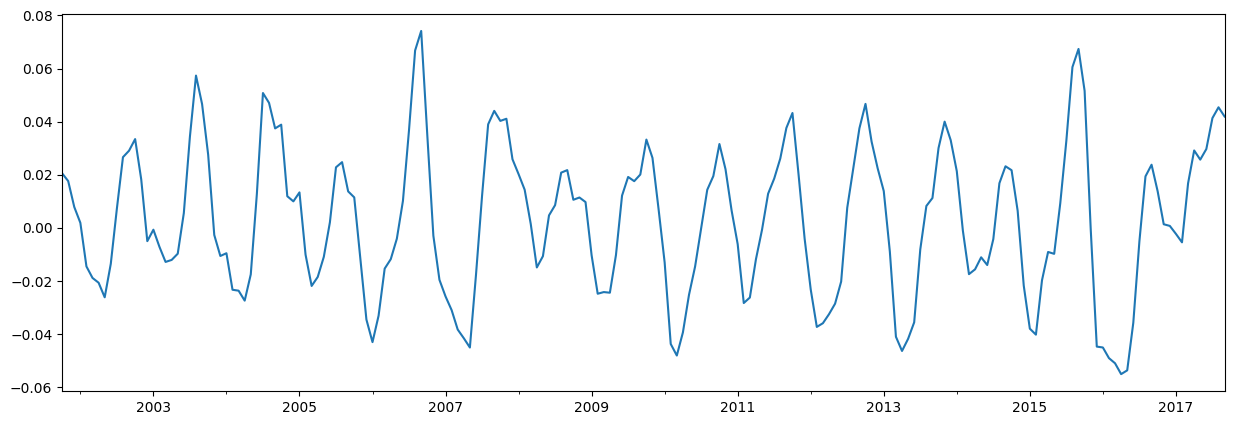

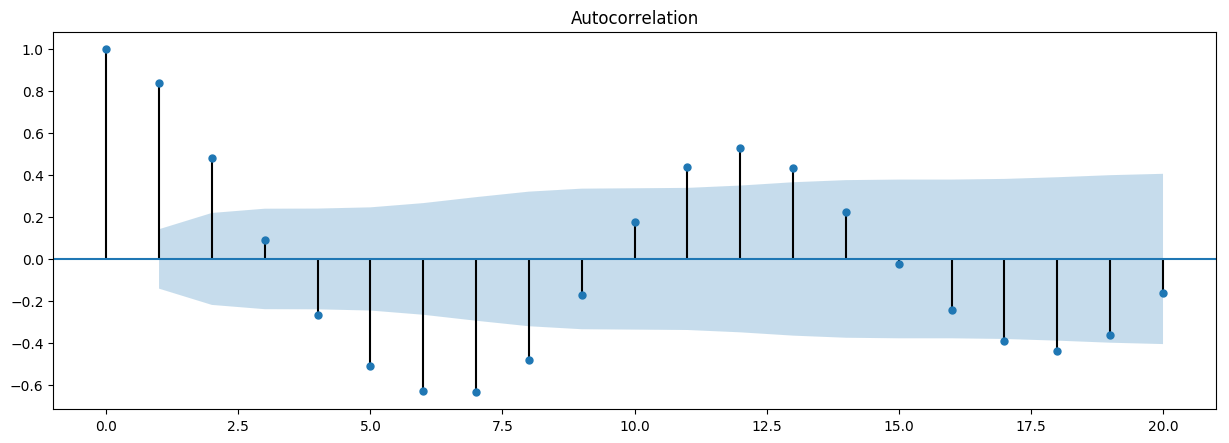

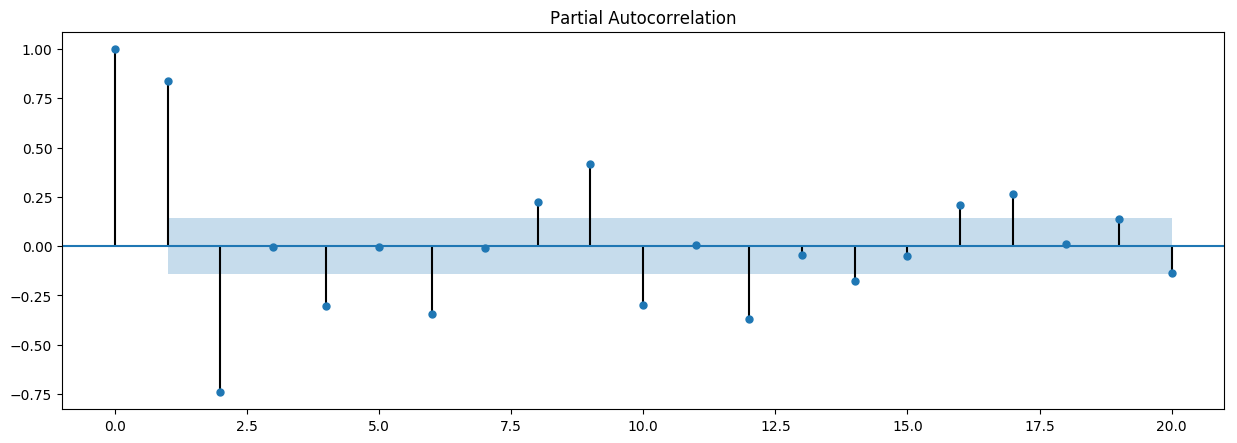

In [95]:
# TREND =  ts_log_decomposed_trend
validation_period_len = 12
print(validation_period_len)
TREND =  ts_log_decomposed_trend.diff(1)[1:]
TREND.plot()
plot_acf(TREND, lags=20);
plot_pacf(TREND, lags=20);
small_stat_test(TREND)
Y_train, Y_valid = split_last_period(TREND, validation_period_len)
X_train, X_valid = split_last_period(D1, validation_period_len)


In [96]:
#Read down variant
DATA = process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS)

DATA[0].tail()

Perak_Month  Perak_Production  Perak_Rainfall  Perak_Area_ma  \
2017-05-01            5           186.958          129.33     312.421053   
2017-06-01            6           165.175          105.82     312.421053   
2017-07-01            7           202.661           85.98     312.421053   
2017-08-01            8           188.525          122.78     312.421053   
2017-09-01            9           171.271          104.88     312.421053   

            Perak_Area_npa  Perak_Area_rpa  Perak_Area_ma_new  Perak_Time  
2017-05-01      349.157895        8.263158         153.390283         232  
2017-06-01      349.157895        8.263158         153.390283         233  
2017-07-01      349.157895        8.263158         153.390283         234  
2017-08-01      349.157895        8.263158         153.390283         235  
2017-09-01      349.157895        8.263158         153.390283         236

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 0.1331
RMSE: 0.1212


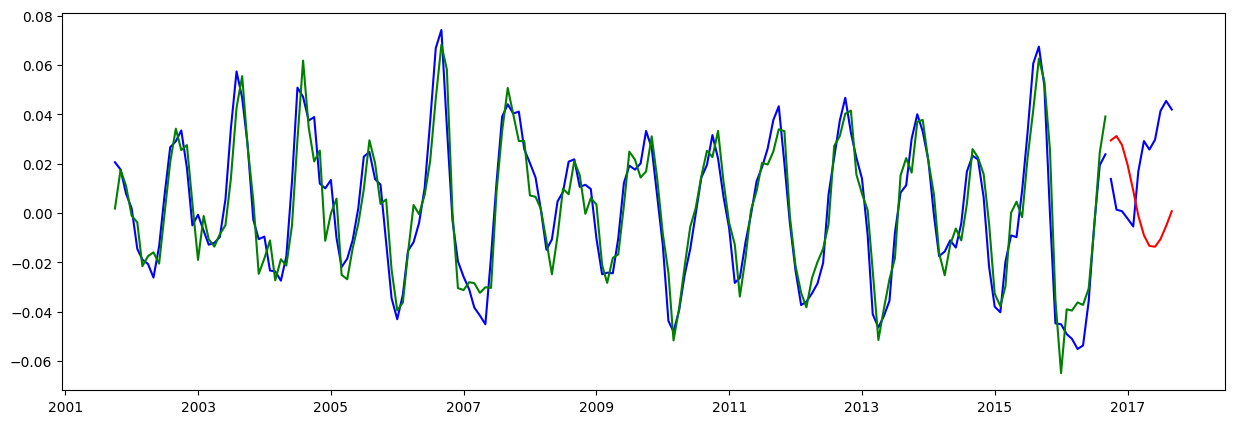

In [97]:
#Bare Y model. This will be baseline for evaluation of new_data efficiency
model, tr_pred, valid_pred = train_valid_ARIMA(Y_train, Y_valid, (3,0,1)) 
plot_ARIMA(Y_train, tr_pred, 'blue', 'green')
plot_ARIMA(Y_valid, valid_pred, 'blue', 'red')

## When we see that model makes presumably good estimation, repeat it in usual data for oter decomposed elements (for single validation period)

In [98]:
p_d_q = (0,0,0) #assume that trend is exodetermined info

model = ARIMA (Y_train, order = p_d_q,  exog=X_train[-len(Y_train):]) 

fitted_model = model.fit(disp=0)
tr_pred = fitted_model.fittedvalues
tr_pred = ts_from_data(data=tr_pred, index=Y_train.index )

valid_pred = fitted_model.forecast (len(Y_valid) ,exog=X_valid[-len(Y_valid):]) [0]
#                                     
# valid_pred = fitted_model.forecast (len(Y_valid) ,exog=X_valid[-len(Y_valid):].diff(1).fillna(method='bfill')  )[0]
valid_pred = ts_from_data(data=valid_pred, index=Y_valid.index )


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 0.1460
RMSE: 0.0493


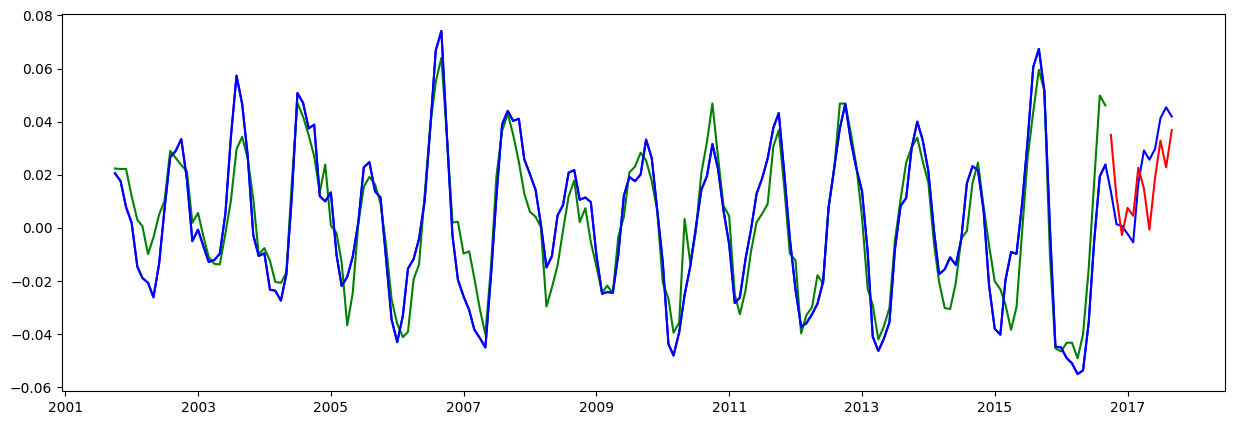

RMSE: 0.0493


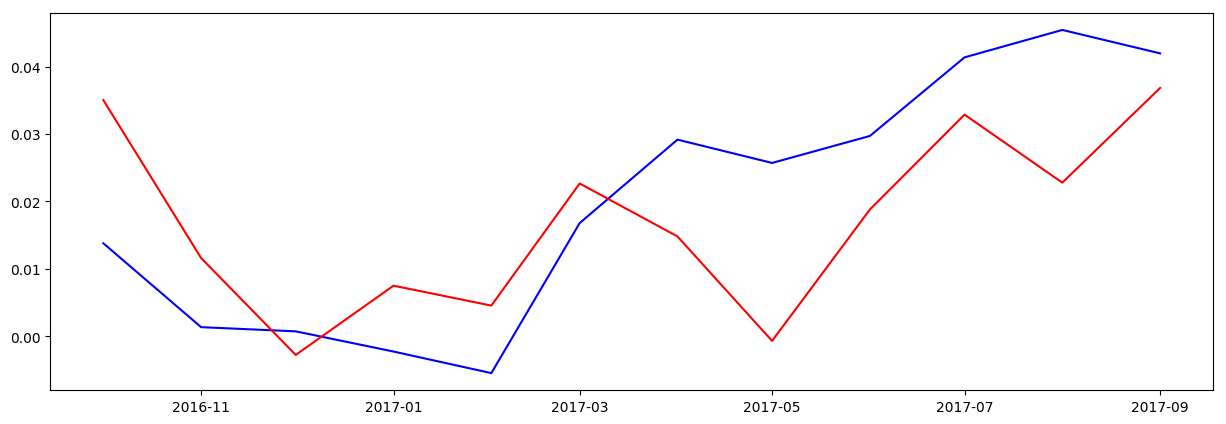

In [99]:
plot_ARIMA(Y_train, tr_pred, 'blue', 'green')
plot_ARIMA(Y_train.append(Y_valid), valid_pred, 'blue', 'red')
plt.show()
plot_ARIMA(Y_valid, valid_pred, 'blue', 'red')

### restore our time period samples from differentiated 

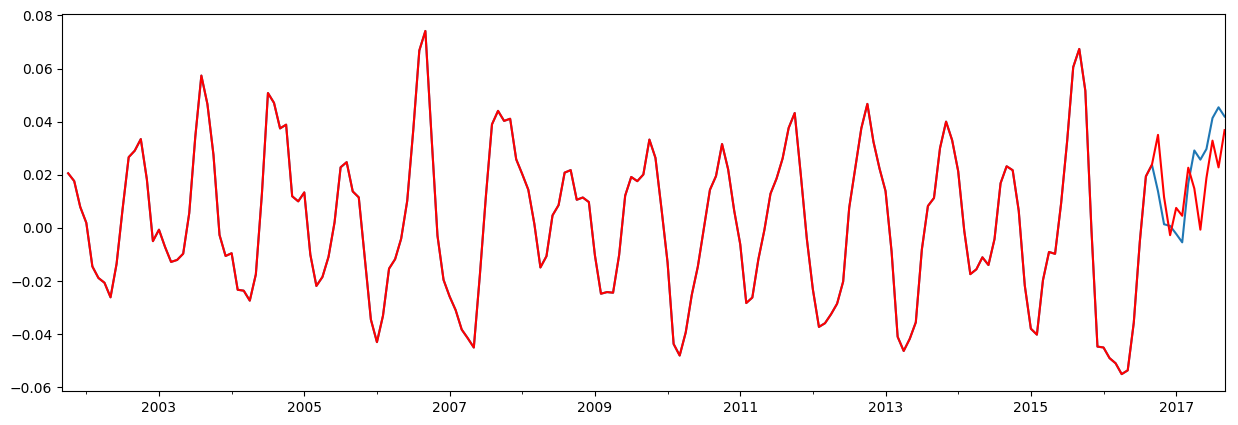

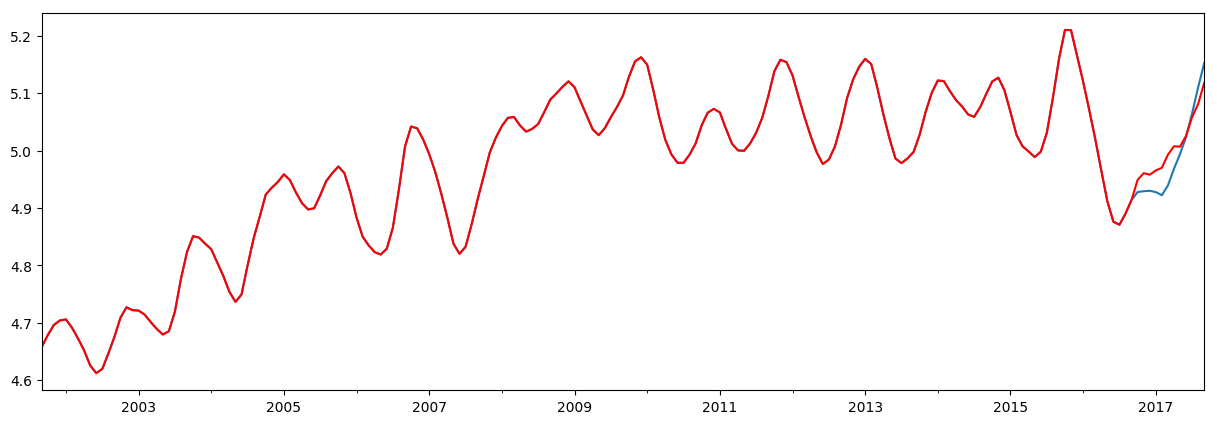

In [100]:
restored_ts_trend_prediction_valid = invert_diff_periods(Y_train.append(valid_pred),
                                               first_period=ts_log_decomposed_trend[:1])

restored_ts_trend_prediction_train = invert_diff_periods( tr_pred ,
                                               first_period=ts_log_decomposed_trend[:1])

ts_log_decomposed_trend.diff(1).plot()
restored_ts_trend_prediction_valid.diff(1).plot(color='red')
plt.show()
ts_log_decomposed_trend.plot()
restored_ts_trend_prediction_valid.plot(color='red')
plt.show()

## P4 combine

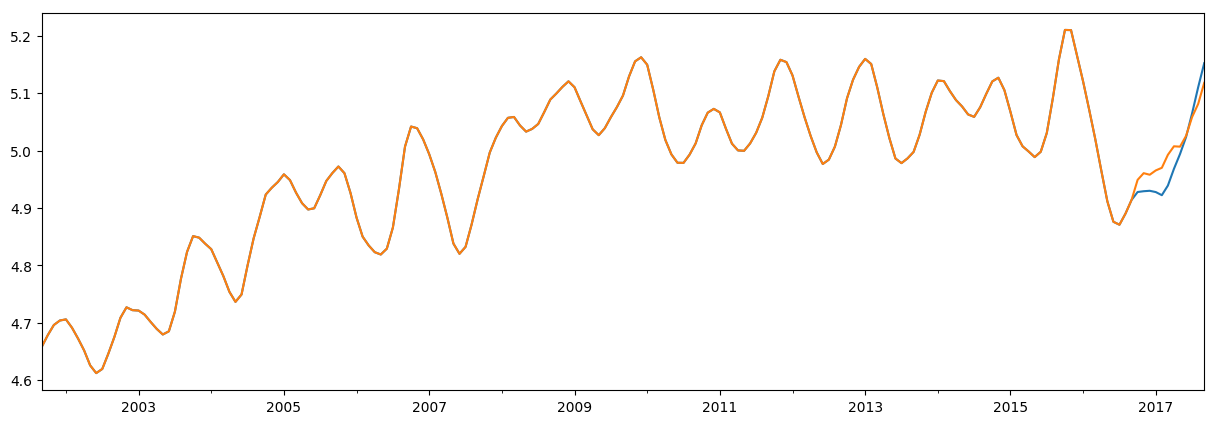

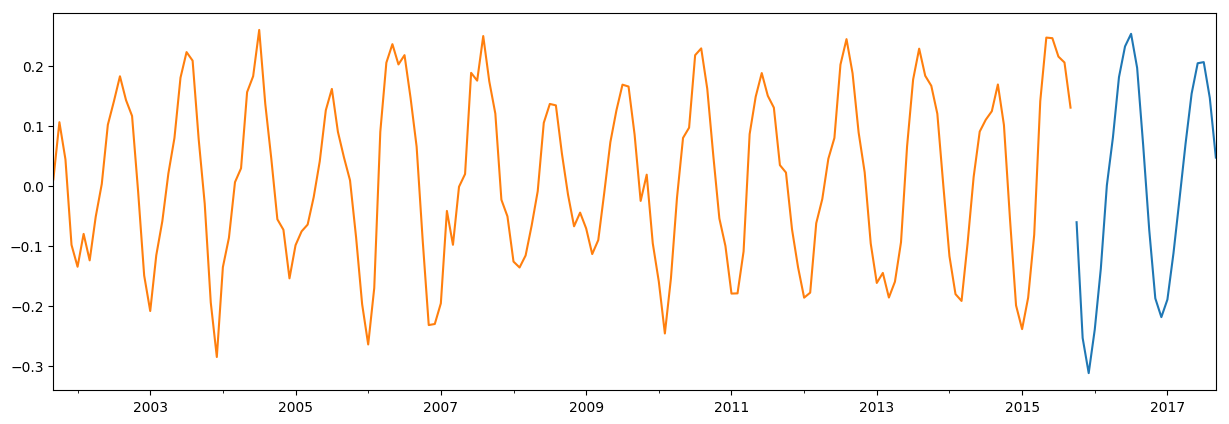

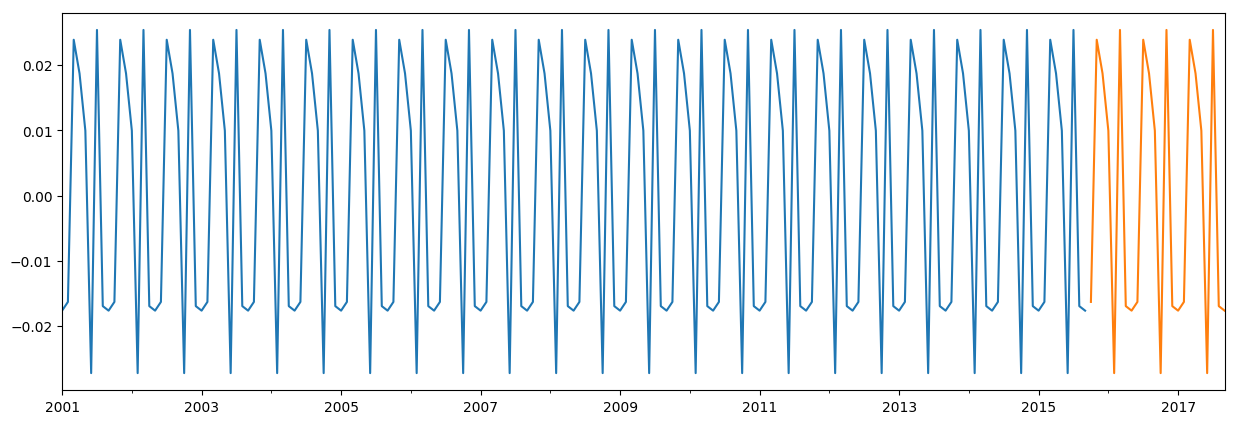

RMSE: 1.2377
RMSE: 0.5819


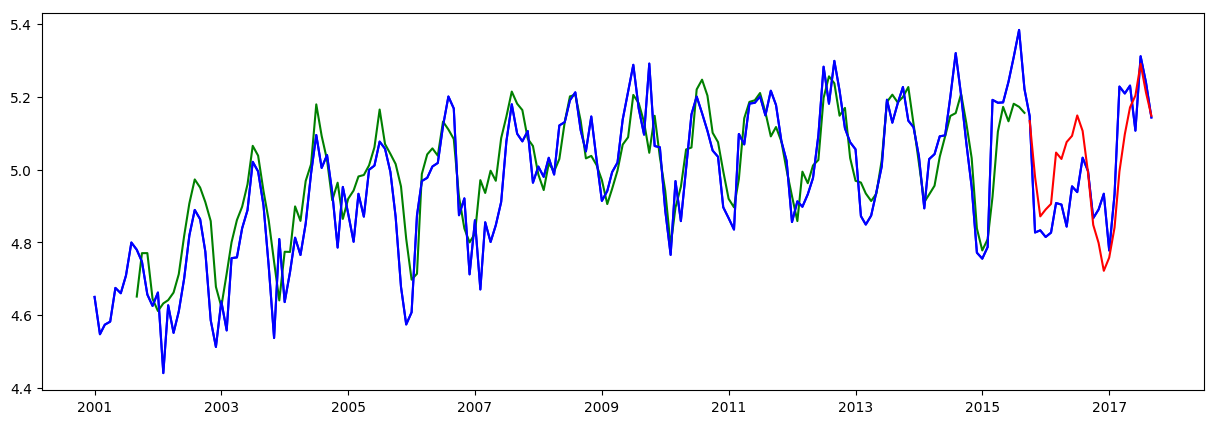

RMSE: 175.2788
RMSE: 86.3881


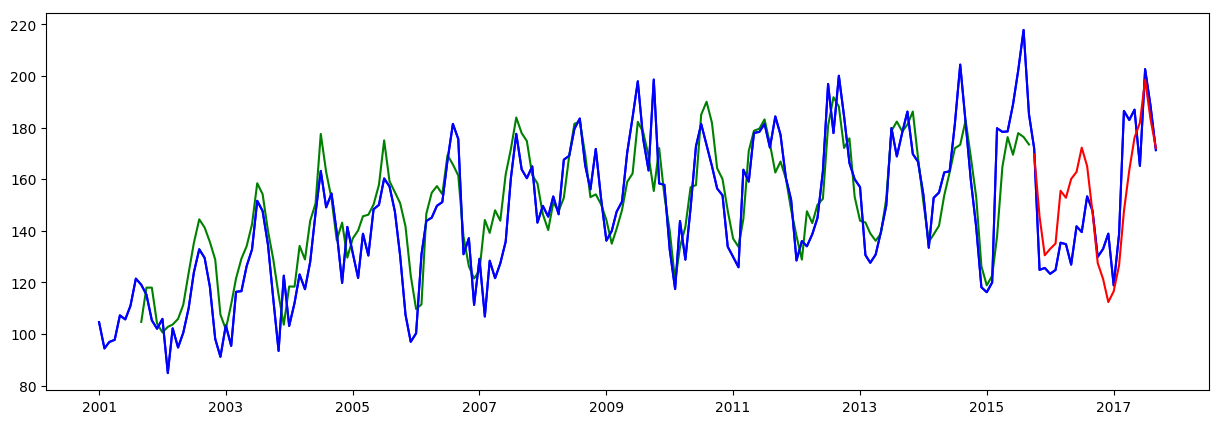

RMSE: 0.3789


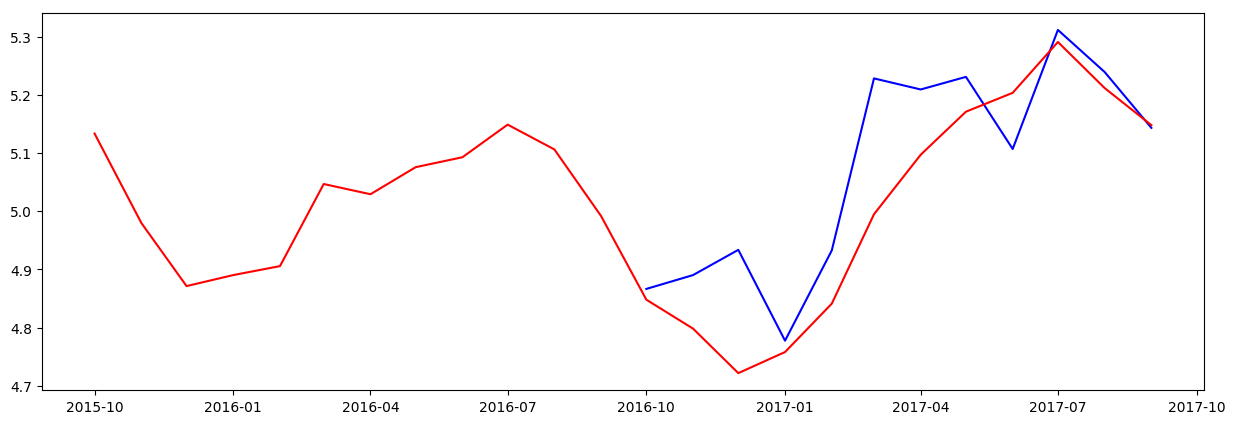

RMSE: 57.6401


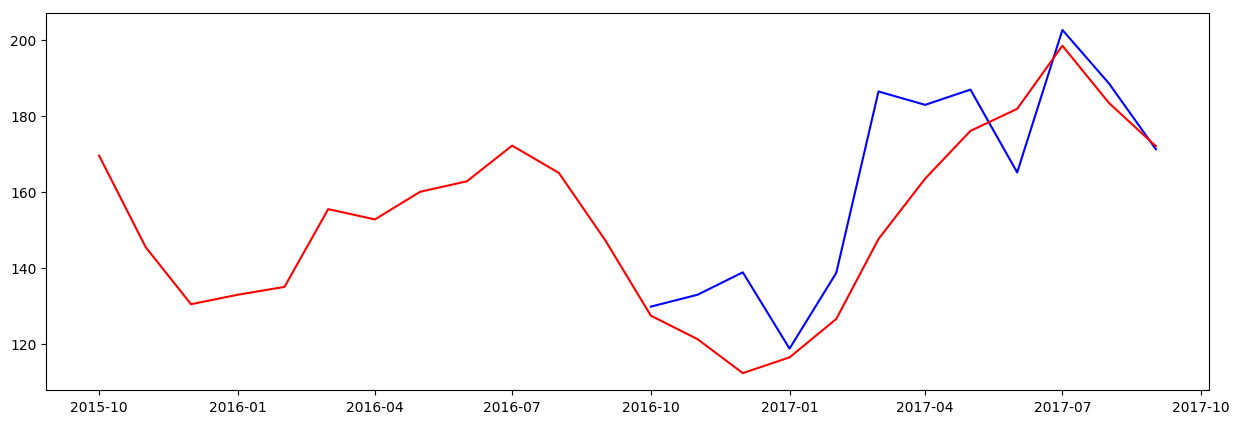

In [101]:

ts_log_decomposed_trend.plot()
restored_ts_trend_prediction_valid.plot()
plt.show()
resid_valid_pred.plot()
resid_tr_pred.plot()
plt.show()
seasonal_tr_pred.plot()
seasonal_valid_pred.plot()
plt.show()


combine_train = restored_ts_trend_prediction_train.add(resid_tr_pred).add(seasonal_tr_pred).dropna()
combine_valid = restored_ts_trend_prediction_valid.add(resid_valid_pred).add(seasonal_valid_pred).dropna()

plot_ARIMA(ts_log, combine_train, 'blue', 'green')
plot_ARIMA(ts_log, combine_valid, 'blue', 'red')
plt.show()


combine_restored_tr = np.exp(combine_train)
combine_restored_valid = np.exp(combine_valid)
plot_ARIMA(raw_ts, combine_restored_tr, 'blue', 'green')
plot_ARIMA(raw_ts, combine_restored_valid, 'blue', 'red')


plt.show()


plot_ARIMA(ts_log[-validation_period_len:], combine_valid, 'blue', 'red')


plt.show()


plot_ARIMA(raw_ts[-validation_period_len:], combine_restored_valid, 'blue', 'red')


# 6) Висновки щодо того, яку модель краще використовувати;


## З опробуваного в цій роботі маємо наступні варіанти зі властивими їм позитивними та негативними сторонами:

   ###  1) Використати звичайний метод і оцінити часовий ряд як як звичайний датасет. (ігноруючи його темпоральну впорядкованість або штучно вносячи дані з часового проміжку жерела впливу в часовий проміжок, де цей вплив корелює із даними, які ми спостерігаємо та передбачаємо. 
        + свобода в маніпуляціях з даними та звичний інструментар.
        - майже таку ж свободу надають інші методи, проте у випадку неспеціалізованих підходів доведеться робити дуже багато громістних маніпуляцій вручну, не маючи можливості дослідити кореляці (без ще більшої кількості роботи)
        
   ### 2) Ітеративні методи побудови.
        + Доповнюємо ряд поступово, симулюючи на кожному кроці наявність даних за короткои проміжок і маємо можливість перенавчати модель.
        + Таким чином можна використовувати будь-які методи, які базуються на наявних даних.
        - Кількість початкової інформації насправді залишається сталою а внесені на кожному кроці помилки отримують мультиплікативиний, а не адитивний ефект з кожною ітерацією.
        
   ### 3) Побудова на базі експоненційного наближення. 
        + Просто і доволі не затратно.
        - Ефективно лише для коротних проміжків або заповнення прогалин,т.я. базується на ковзному вікні 
        
   ### 4) ARIMA моделі. 
        + Спеціалізовані для використання з часовими рядами. Враховують часову складову даних і пристосовані для виявлення кореляційного зв'язку між ними.
        + Доступний спосіб 
    
## Щодо використання джерела даних для побудови даної моделі:
   
   ### 1) Побудова на основі диферецнійованих даних (нормалізований "один канал")
        + Канал лише один, менше роботи, кращий контроль (немає ризику, що помилки в двох прогнозах накладуться несприятливим чином.
        - Помилка в прогнозі на диференційованому ряді після відновлення до початкового стану приведе до поширення її на всю подальшу вибірку.
        
   ### 2) Прогнозування на основі декомпонованих даних.
        - Більше роботи з побудови моделей.
        + Частина моделей "Хороші" - легко прогнозовані.
        + Дані окремих моделей мають збирають в собі окремі особливості початкової вибірки, тому їх легше виявляти і "задовльняти" окремо, аніж всі в одні моделі. 
    
   ### 3) Використання додаткових даних, пов'язаних із того ж джерела, що й вибірка. 
        + дозволяє не просто екстраполювати спостереження, а пояснити його
        - відсутність таких даних на перід прогнозування призводить до того, що їх або теж доведеться генерувати, а це додаткове джерело похибок.
        + Натомість можна навчати модель на даниих з часовим зміщенням у минуле порівнюваного розміру з періодом на який маємо зробити прогноз.


 # 7) Прогноз на наступний рік

In [102]:
from copy import copy
from dateutil import relativedelta
def next_mounth(date):
    return date + relativedelta.relativedelta(months=1)

In [103]:
def generate_prediction_index(available_training_data, raw_data):
    final = raw_data.index[-1] + relativedelta.relativedelta(months=13)
    start = available_training_data.index[-1] + relativedelta.relativedelta(months=1)
    index = list()
    while start < final:
        index.append(copy(copy(start)) )
        start = start + relativedelta.relativedelta(months=1)
    print ("Providing [{}] timestamps from [{}] to [{}]".format(len(index),index[0],index[-1]))
    return index

# Model on decompositions

In [104]:
prediction_index = generate_prediction_index (available_training_data=ts_log_decomposed_residuals, raw_data=raw_ts)

Providing [12] timestamps from [2017-10-01 00:00:00] to [2018-09-01 00:00:00]


In [105]:
prediction_index = pd.Index(prediction_index)
prediction_index

DatetimeIndex(['2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01'],
              dtype='datetime64[ns]', freq=None)

In [106]:
D_temp = DATA[0].copy()
masks = [
#     "Perak_Area_ma",
         "Perak_Area_npa",
#          "Perak_Area_rpa",
         "Perak_Area_ma_new",
         'Perak_Production',
         'Perak_Rainfall'
        ]
shifts =  [  8,9,10,11,12, 15,  18, 24]

D_temp  = D_temp.reindex(DATA[0].index.append(prediction_index) )
D2 = D_temp.copy()
for m in masks:
    for i in shifts:
        D2[ (m + "_{}").format(i) ] = D_temp[m].shift(i)
        D2.fillna(method = 'backfill',  inplace = True)
        D2.fillna(method = 'ffill',  inplace = True)
D2 = D2.drop(
    [ 'Perak_Month', 'Perak_Time'  , "Perak_Area_ma",
         "Perak_Area_npa",
         "Perak_Area_rpa",
         "Perak_Area_ma_new",
         'Perak_Production',
         'Perak_Rainfall' ], axis=1)     

In [107]:
D2.tail()

Perak_Area_npa_8  Perak_Area_npa_9  Perak_Area_npa_10  \
2018-05-01        349.157895        349.157895         349.157895   
2018-06-01        349.157895        349.157895         349.157895   
2018-07-01        349.157895        349.157895         349.157895   
2018-08-01        349.157895        349.157895         349.157895   
2018-09-01        349.157895        349.157895         349.157895   

            Perak_Area_npa_11  Perak_Area_npa_12  Perak_Area_npa_15  \
2018-05-01         349.157895         349.157895         349.157895   
2018-06-01         349.157895         349.157895         349.157895   
2018-07-01         349.157895         349.157895         349.157895   
2018-08-01         349.157895         349.157895         349.157895   
2018-09-01         349.157895         349.157895         349.157895   

            Perak_Area_npa_18  Perak_Area_npa_24  Perak_Area_ma_new_8  \
2018-05-01         398.000000              398.0           153.390283   
2018-06-01         398.000000              398.0           153.390283   
2018-07-01         349.157895              398.0           153.390283   
2018-08-01         349.157895              398.0           153.390283   
2018-09-01         349.157895              398.0           153.390283   

            Perak_Area_ma_new_9        ...          Perak_Production_18  \
2018-05-01           153.390283        ...                      132.994   
2018-06-01           153.390283        ...                      138.888   
2018-07-01           153.390283        ...                      118.818   
2018-08-01           153.390283        ...                      138.743   
2018-09-01           153.390283        ...                      186.465   

            Perak_Production_24  Perak_Rainfall_8  Perak_Rainfall_9  \
2018-05-01              126.876            104.88            122.78   
2018-06-01              141.734            104.88            104.88   
2018-07-01              139.503            104.88            104.88   
2018-08-01              153.346            104.88            104.88   
2018-09-01              147.820            104.88            104.88   

            Perak_Rainfall_10  Perak_Rainfall_11  Perak_Rainfall_12  \
2018-05-01              85.98             105.82             129.33   
2018-06-01             122.78              85.98             105.82   
2018-07-01             104.88             122.78              85.98   
2018-08-01             104.88             104.88             122.78   
2018-09-01             104.88             104.88             104.88   

            Perak_Rainfall_15  Perak_Rainfall_18  Perak_Rainfall_24  
2018-05-01            230.612            249.300             239.39  
2018-06-01            218.084            175.024             104.30  
2018-07-01            223.220            293.520             175.76  
2018-08-01            129.330            230.612             143.64  
2018-09-01            105.820            218.084             206.40  

[5 rows x 32 columns]

In [108]:
ts_log_decomposed_seasonal
ts_log_decomposed_residuals
forecast_period_len = 12

In [109]:
X_train.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01'],
              dtype='datetime64[ns]', length=189, freq=None)

In [110]:
# trend 

In [111]:
TREND =  ts_log_decomposed_trend.diff(1)[1:]

Y_train = TREND

X_train, X_valid = split_last_period(D2[9:], forecast_period_len)
p_d_q = (0,0,0)

model = ARIMA (Y_train, order = p_d_q,  exog=X_train) 

fitted_model = model.fit(disp=0)

train_trend = fitted_model.fittedvalues
train_trend = ts_from_data(data=train_trend, index=Y_train.index )

valid_trend = fitted_model.forecast (forecast_period_len ,exog=X_valid[-forecast_period_len:] ) [0]
valid_trend = ts_from_data(data=valid_trend, index=prediction_index )

Data span from: [2001-10-01 00:00:00]  to: [2018-09-01 00:00:00]
Split_border [2017-10-01 00:00:00]  


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [112]:
valid_trend_res = invert_diff_periods(Y_train.append(valid_trend),
                                               first_period=ts_log_decomposed_trend[:1])
train_trend_res = invert_diff_periods(train_trend,
                                               first_period=ts_log_decomposed_trend[:1])



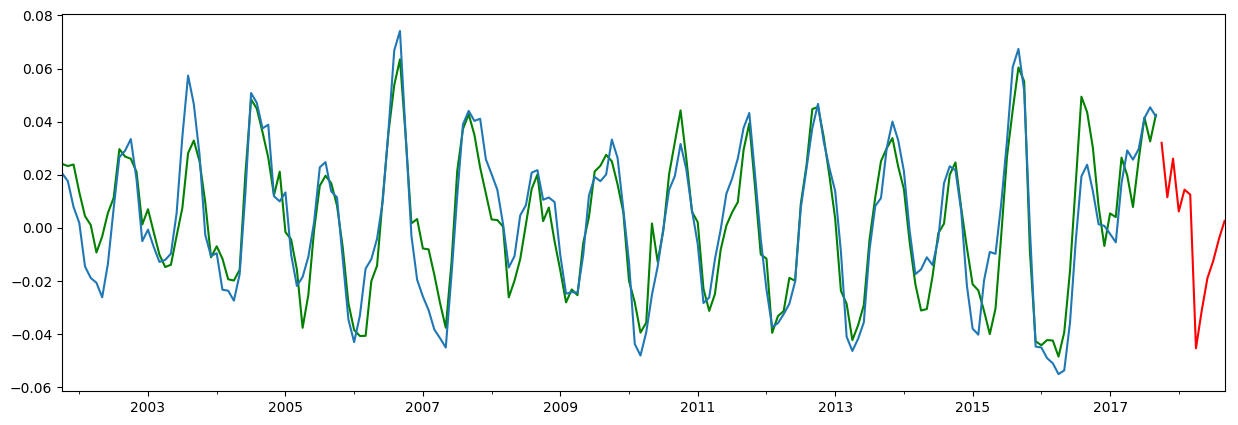

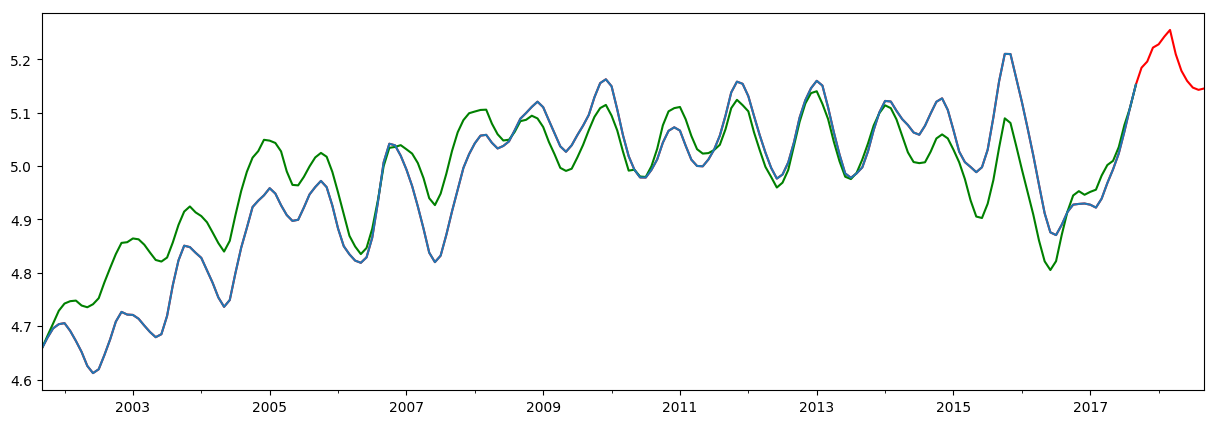

In [113]:
valid_trend.plot(color='red')
train_trend.plot(color='green')
TREND.plot()
plt.show()
valid_trend_res.plot(color='red')
train_trend_res.plot(color='green')
ts_log_decomposed_trend.plot()
plt.show()

# residials

In [114]:
Y_train = ts_log_decomposed_residuals
# X_train, X_valid = split_last_period(D1, forecast_period_len)
p_d_q = (9,0,3)

model = ARIMA (Y_train, order = p_d_q)
fitted_model = model.fit(disp=0)

train_resid = fitted_model.fittedvalues
train_resid = ts_from_data(data=train_resid, index=Y_train.index )

valid_resid = fitted_model.forecast (forecast_period_len) [0]
valid_resid = ts_from_data(data=valid_resid, index=prediction_index)


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


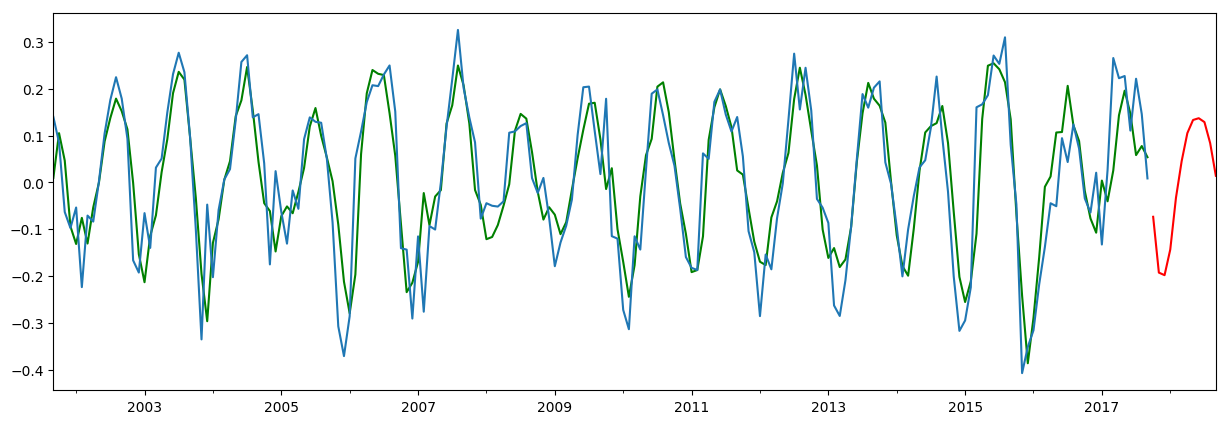

In [115]:
valid_resid.plot(color='red')
train_resid.plot(color='green')
ts_log_decomposed_residuals.plot()

# seasons

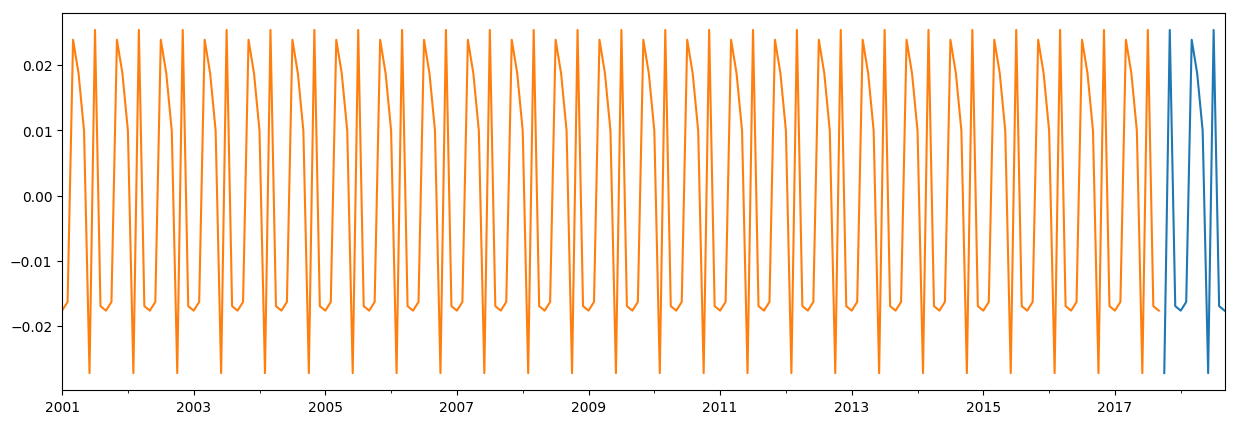

In [116]:
train = ts_log_decomposed_seasonal
series_train = train.copy()
series_valid = pd.Series(index = prediction_index, data=train.data[-len(prediction_index):] )
series_valid.plot()
ts_log_decomposed_seasonal.plot()


# Combine

RMSE: 1.3600
RMSE: 0.0000


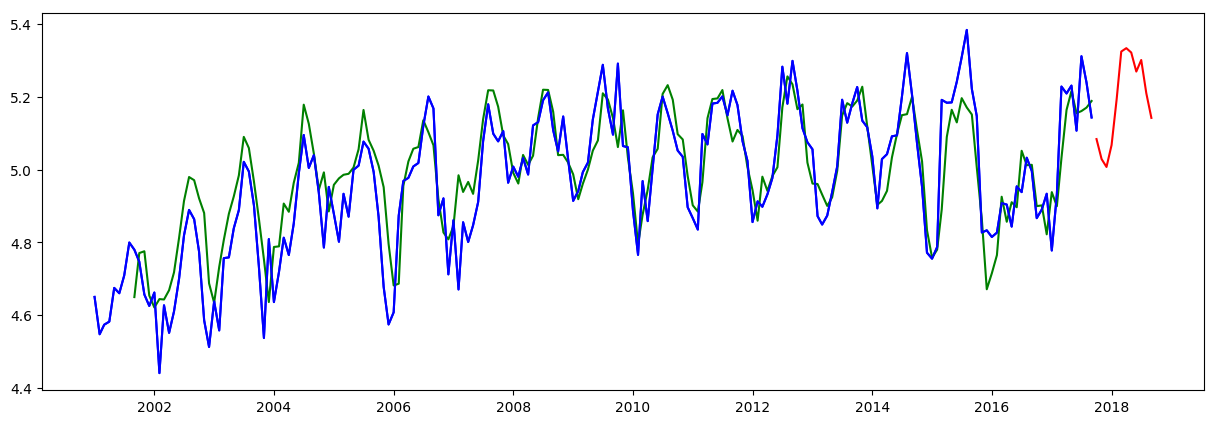

RMSE: 193.5899
RMSE: 0.0000


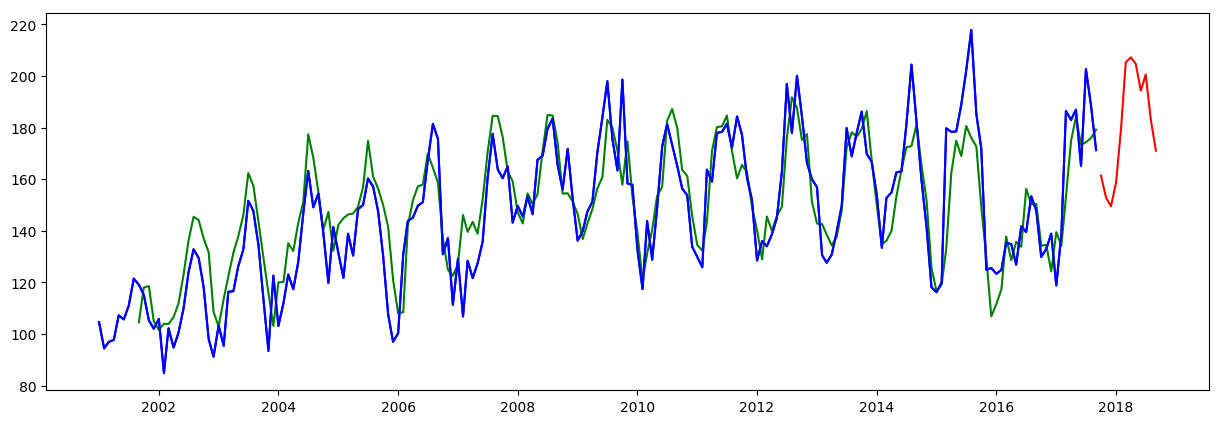

RMSE: 0.0000


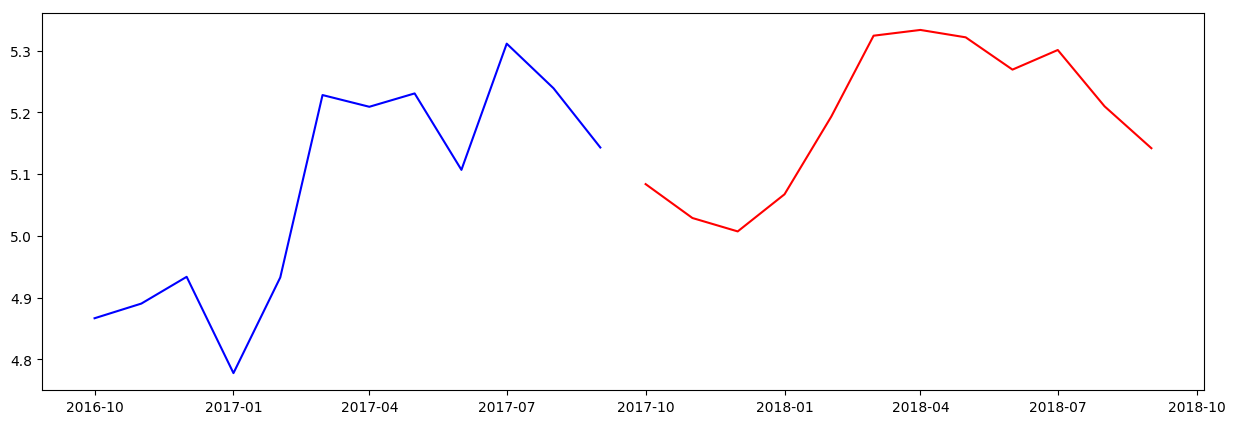

In [117]:
combine_train = train_trend_res.add(series_train).add(train_resid).dropna()
combine_valid = valid_trend_res.add(series_valid).add(valid_resid).dropna()

plot_ARIMA(ts_log, combine_train, 'blue', 'green')
plot_ARIMA(ts_log, combine_valid, 'blue', 'red')
plt.show()


combine_restored_tr = np.exp(combine_train)
combine_restored_valid = np.exp(combine_valid)
plot_ARIMA(raw_ts, combine_restored_tr, 'blue', 'green')
plot_ARIMA(raw_ts, combine_restored_valid, 'blue', 'red')


plt.show()


plot_ARIMA(ts_log[-validation_period_len:], combine_valid, 'blue', 'red')

In [118]:
combine_restored_valid

2017-10-01    161.402316
2017-11-01    152.775699
2017-12-01    149.493124
2018-01-01    158.761831
2018-02-01    180.092412
2018-03-01    205.292505
2018-04-01    207.217604
2018-05-01    204.750347
2018-06-01    194.312758
2018-07-01    200.587336
2018-08-01    183.083304
2018-09-01    171.072470
dtype: float64